<a href="https://colab.research.google.com/github/86HenriqueSilva/challenge1-data-science/blob/main/Desafio1_Ciencias_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Base de Dados para Análise.**

Carregamento e Normalização de Dados de Lojas




In [ ]:
import pandas as pd
from decimal import Decimal, ROUND_HALF_UP
from babel.numbers import format_currency
from IPython.display import display, HTML

urls_lojas = {
    'loja_1': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_1.csv",
    'loja_2': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_2.csv",
    'loja_3': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_3.csv",
    'loja_4': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_4.csv"
}

colunas_esperadas = [
    "Produto","Categoria do Produto","Preço","Frete","Data da Compra",
    "Vendedor","Local da compra","Avaliação da compra","Tipo de pagamento",
    "Quantidade de parcelas","lat","lon"
]

def carregar_normalizar(nome_loja, url):
    # 1) Ler CSV
    df = pd.read_csv(url, encoding="utf-8")
    # 2) Validar esquema
    if list(df.columns) != colunas_esperadas:
        raise ValueError(f"Esquema inesperado em {nome_loja}: {list(df.columns)}")
    # 3) Datas: dd/mm/aaaa -> datetime64
    df["Data da Compra"] = pd.to_datetime(df["Data da Compra"], format="%d/%m/%Y", errors="coerce")
    # 4) Tipos numéricos
    df["Preço"] = pd.to_numeric(df["Preço"], errors="coerce")
    df["Frete"] = pd.to_numeric(df["Frete"], errors="coerce")
    # 5) Opcional: centavos inteiros para precisão financeira
    df["preco_cent"] = df["Preço"].apply(lambda x: int(Decimal(str(x)).scaleb(2).quantize(Decimal('1'), rounding=ROUND_HALF_UP)) if pd.notna(x) else pd.NA)
    df["frete_cent"] = df["Frete"].apply(lambda x: int(Decimal(str(x)).scaleb(2).quantize(Decimal('1'), rounding=ROUND_HALF_UP)) if pd.notna(x) else pd.NA)
    # 6) Derivados temporais úteis
    df["ano"] = df["Data da Compra"].dt.year
    df["mes"] = df["Data da Compra"].dt.to_period("M").dt.to_timestamp()
    # 7) Identificação de origem
    df["loja"] = nome_loja
    return df

print("--- Carregando e normalizando ---")
dfs = []
for nome_loja, url in urls_lojas.items():
    df = carregar_normalizar(nome_loja, url)
    print(f"✅ {nome_loja}: {df.shape[0]} linhas")
    dfs.append(df)

full = pd.concat(dfs, ignore_index=True)

display(HTML("<h3>Prévia formatada (sem alterar dtypes)</h3>"))
display(
    full.head(10).style.format({
        "Preço": lambda v: format_currency(v, "BRL", locale="pt_BR") if pd.notna(v) else "",
        "Frete": lambda v: format_currency(v, "BRL", locale="pt_BR") if pd.notna(v) else ""
    })
)


Processo de Unificação

In [59]:
import pandas as pd
from decimal import Decimal, ROUND_HALF_UP
from babel.numbers import format_currency
from IPython.display import display, HTML

# Assume que urls_lojas já está definido na célula anterior: {'loja_1': '...', ...}

COLUNAS_ESPERADAS = [
    "Produto","Categoria do Produto","Preço","Frete","Data da Compra",
    "Vendedor","Local da compra","Avaliação da compra","Tipo de pagamento",
    "Quantidade de parcelas","lat","lon"
]

DTYPES_BASE = {
    "Produto": "string",
    "Categoria do Produto": "string",
    "Preço": "float64",            # cálculo em float, precisão final via centavos/Decimal
    "Frete": "float64",
    "Vendedor": "string",
    "Local da compra": "string",
    "Avaliação da compra": "Int64",   # inteiro anulável
    "Tipo de pagamento": "string",
    "Quantidade de parcelas": "Int64",
    "lat": "float64",
    "lon": "float64",
}

def to_cents(x):
    if pd.isna(x):
        return pd.NA
    d = Decimal(str(x)).quantize(Decimal("0.01"), rounding=ROUND_HALF_UP)
    return int((d * 100))

def carregar_normalizar(nome_loja, url):
    # 1) Leitura
    df = pd.read_csv(url, encoding="utf-8")
    # 2) Validação e reordenação de colunas
    if set(COLUNAS_ESPERADAS) - set(df.columns):
        raise ValueError(f"Colunas faltando em {nome_loja}: {set(COLUNAS_ESPERADAS) - set(df.columns)}")
    df = df[COLUNAS_ESPERADAS]
    # 3) Datas dd/mm/aaaa -> datetime64
    df["Data da Compra"] = pd.to_datetime(df["Data da Compra"], format="%d/%m/%Y", errors="coerce")
    # 4) Conversões numéricas seguras
    df["Preço"] = pd.to_numeric(df["Preço"], errors="coerce")
    df["Frete"] = pd.to_numeric(df["Frete"], errors="coerce")
    # 5) Normalização leve de strings
    for c in ["Produto","Categoria do Produto","Vendedor","Local da compra","Tipo de pagamento"]:
        df[c] = df[c].astype("string").str.strip()
    # 6) Dtypes alvo
    df = df.astype(DTYPES_BASE, errors="ignore")
    # 7) Centavos inteiros para precisão financeira
    df["preco_cent"]  = df["Preço"].apply(to_cents)
    df["frete_cent"]  = df["Frete"].apply(to_cents)
    df["receita_total_cent"] = df["preco_cent"].fillna(0) + df["frete_cent"].fillna(0)
    # 8) Métricas auxiliares de tempo
    df["ano"] = df["Data da Compra"].dt.year
    df["mes"] = df["Data da Compra"].dt.to_period("M").dt.to_timestamp()
    # 9) Identificação da origem
    df["loja"] = nome_loja
    return df

print("--- Carregando e normalizando ---")
dfs_norm = []
for loja, url in urls_lojas.items():
    df = carregar_normalizar(loja, url)
    print(f"✅ {loja}: {df.shape[0]} linhas, {df.shape[1]} colunas")
    dfs_norm.append(df)

# Unificação e deduplicação (opcional)
full = pd.concat(dfs_norm, ignore_index=True)
full = full.drop_duplicates(ignore_index=True)

# KPIs por loja com base em centavos (precisão)
kpis = (
    full.groupby("loja", as_index=False)
        .agg(
            pedidos=("Produto", "size"),
            receita_total_cent=("receita_total_cent", "sum"),
            preco_medio=("Preço", "mean"),
            frete_medio=("Frete", "mean"),
            avaliacao_media=("Avaliação da compra", "mean"),
            parcelas_media=("Quantidade de parcelas", "mean"),
        )
)
# Converte centavos para reais para apresentação
kpis["receita_total_brl"] = kpis["receita_total_cent"].div(100)

display(HTML("<h3>KPIs por Loja</h3>"))
display(
    kpis[["loja","pedidos","receita_total_brl","preco_medio","frete_medio","avaliacao_media","parcelas_media"]]
      .style.format({
          "receita_total_brl": lambda v: format_currency(v, "BRL", locale="pt_BR"),
          "preco_medio":      lambda v: format_currency(v, "BRL", locale="pt_BR"),
          "frete_medio":      lambda v: format_currency(v, "BRL", locale="pt_BR"),
      })
)

# Tendência mensal (receita e pedidos)
tendencia = (
    full.groupby(["loja","mes"], as_index=False)
        .agg(receita_total_cent=("receita_total_cent","sum"),
             pedidos=("Produto","size"))
)
tendencia["receita_total_brl"] = tendencia["receita_total_cent"].div(100)

display(HTML("<h3>Tendência Mensal (amostra)</h3>"))
display(tendencia.sort_values(["loja","mes"]).head(12))


--- Carregando e normalizando ---
✅ loja_1: 2359 linhas, 18 colunas
✅ loja_2: 2359 linhas, 18 colunas
✅ loja_3: 2359 linhas, 18 colunas
✅ loja_4: 2358 linhas, 18 colunas


loja        mes  receita_total_cent  pedidos  receita_total_brl
0   loja_1 2020-01-01             4645018       71           46450.18
1   loja_1 2020-02-01             5627784       62           56277.84
2   loja_1 2020-03-01             4431116       71           44311.16
3   loja_1 2020-04-01             4729789       52           47297.89
4   loja_1 2020-05-01             5417423       62           54174.23
5   loja_1 2020-06-01             3692798       52           36927.98
6   loja_1 2020-07-01             4928212       62           49282.12
7   loja_1 2020-08-01             4373199       54           43731.99
8   loja_1 2020-09-01             4248377       65           42483.77
9   loja_1 2020-10-01             2971740       45           29717.40
10  loja_1 2020-11-01             2792984       53           27929.84
11  loja_1 2020-12-01             3965523       66           39655.23

In [60]:
import pandas as pd
from decimal import Decimal, ROUND_HALF_UP
from babel.numbers import format_currency
from IPython.display import display, HTML

# 1) Configurações de apresentação (não alteram dtypes de cálculo)
pd.set_option("styler.format.thousands", ".")  # milhar com ponto no PT-BR
pd.set_option("styler.format.decimal", ",")    # decimal com vírgula no PT-BR

COLUNAS_ESPERADAS = [
    "Produto","Categoria do Produto","Preço","Frete","Data da Compra",
    "Vendedor","Local da compra","Avaliação da compra","Tipo de pagamento",
    "Quantidade de parcelas","lat","lon"
]

def to_cents(x):
    if pd.isna(x): return 0
    d = Decimal(str(x)).quantize(Decimal("0.01"), rounding=ROUND_HALF_UP)
    return int(d * 100)

def carregar_normalizar(nome_loja, url):
    df = pd.read_csv(url, encoding="utf-8")
    # Validar e ordenar colunas
    df = df[COLUNAS_ESPERADAS]
    # Datas dd/mm/aaaa -> datetime64
    df["Data da Compra"] = pd.to_datetime(df["Data da Compra"], format="%d/%m/%Y", errors="coerce")
    # Numéricos robustos
    df["Preço"] = pd.to_numeric(df["Preço"], errors="coerce")
    df["Frete"] = pd.to_numeric(df["Frete"], errors="coerce")
    # Strings básicas
    for c in ["Produto","Categoria do Produto","Vendedor","Local da compra","Tipo de pagamento"]:
        df[c] = df[c].astype("string").str.strip()
    # Centavos para precisão em somas
    df["preco_cent"] = df["Preço"].apply(to_cents)
    df["frete_cent"] = df["Frete"].apply(to_cents)
    df["receita_total_cent"] = df["preco_cent"] + df["frete_cent"]
    # Derivados de tempo para análises
    df["ano"] = df["Data da Compra"].dt.year
    df["mes"] = df["Data da Compra"].dt.to_period("M").dt.to_timestamp()
    # Origem
    df["loja"] = nome_loja
    return df

# 2) Carregamento
dfs = []
for loja, url in urls_lojas.items():
    dfs.append(carregar_normalizar(loja, url))
full = pd.concat(dfs, ignore_index=True)

# 3) KPIs por loja (cálculo em numérico)
kpis = (
    full.groupby("loja", as_index=False)
        .agg(
            pedidos=("Produto", "size"),
            receita_produtos=("Preço", "sum"),
            receita_frete=("Frete", "sum"),
            gmv=("receita_total_cent", "sum"),
            ticket_medio=("receita_total_cent", "mean"),
            avaliacao_media=("Avaliação da compra","mean"),
            parcelas_media=("Quantidade de parcelas","mean"),
        )
)
# Converter centavos de GMV/ticket para reais para exibição
kpis["gmv_brl"] = kpis["gmv"] / 100
kpis["ticket_medio_brl"] = kpis["ticket_medio"] / 100
kpis["frete_pct"] = (kpis["receita_frete"] / (kpis["receita_produtos"] + kpis["receita_frete"])).fillna(0)

# 4) Exibições legíveis (sem alterar dtypes subjacentes)
def fmt_brl(v):
    return "" if pd.isna(v) else format_currency(v, "BRL", locale="pt_BR")

display(HTML("<h3>KPIs por Loja (legível)</h3>"))
display(
    kpis[["loja","pedidos","gmv_brl","ticket_medio_brl","receita_produtos","receita_frete","frete_pct","avaliacao_media","parcelas_media"]]
      .style.format({
          "gmv_brl": fmt_brl,
          "ticket_medio_brl": fmt_brl,
          "receita_produtos": fmt_brl,
          "receita_frete": fmt_brl,
          "frete_pct": "{:.2%}",
          "avaliacao_media": "{:.2f}",
          "parcelas_media": "{:.2f}",
      })
)

display(HTML("<h3>Amostra de Linhas (legível)</h3>"))
display(
    full.sample(10, random_state=42)[
        ["loja","Data da Compra","Produto","Categoria do Produto","Preço","Frete","Tipo de pagamento","Quantidade de parcelas","Local da compra","lat","lon"]
    ]
    .assign(
        Data=lambda d: d["Data da Compra"].dt.strftime("%d/%m/%Y"),
    )
    .drop(columns=["Data da Compra"])
    .style.format({
        "Preço": fmt_brl,
        "Frete": fmt_brl,
        "lat": "{:.2f}",
        "lon": "{:.2f}",
        "Quantidade de parcelas": "{:,.0f}",
    })
)


/tmp/ipython-input-3947021059.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipython-input-3947021059.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(slope_trend)
/tmp/ipython-input-3947021059.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pct_change_begin_end)


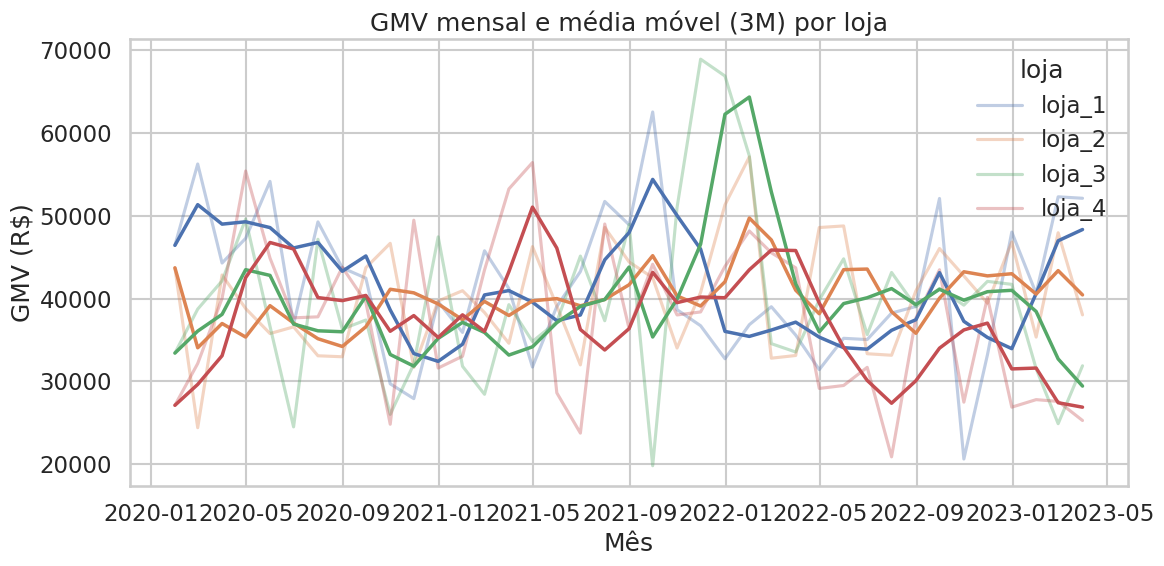

/tmp/ipython-input-3947021059.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=totais, x="loja", y="gmv_brl", palette="viridis")


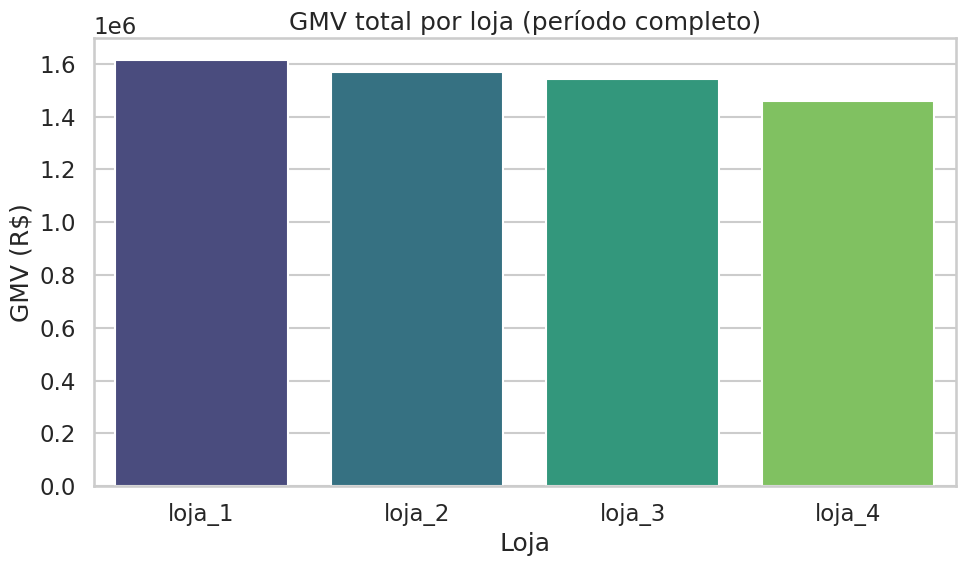

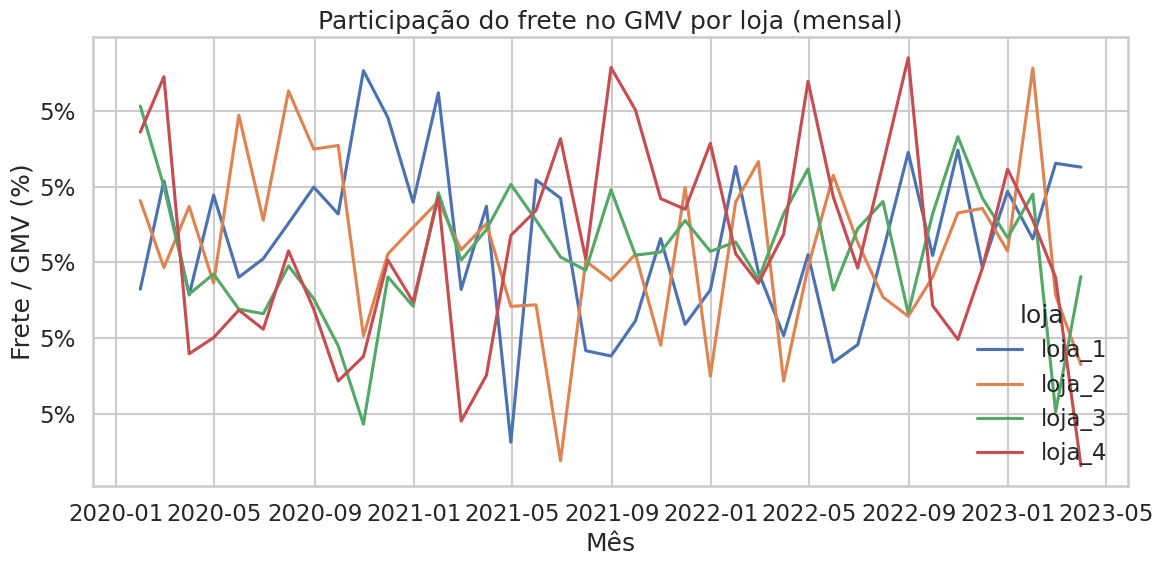

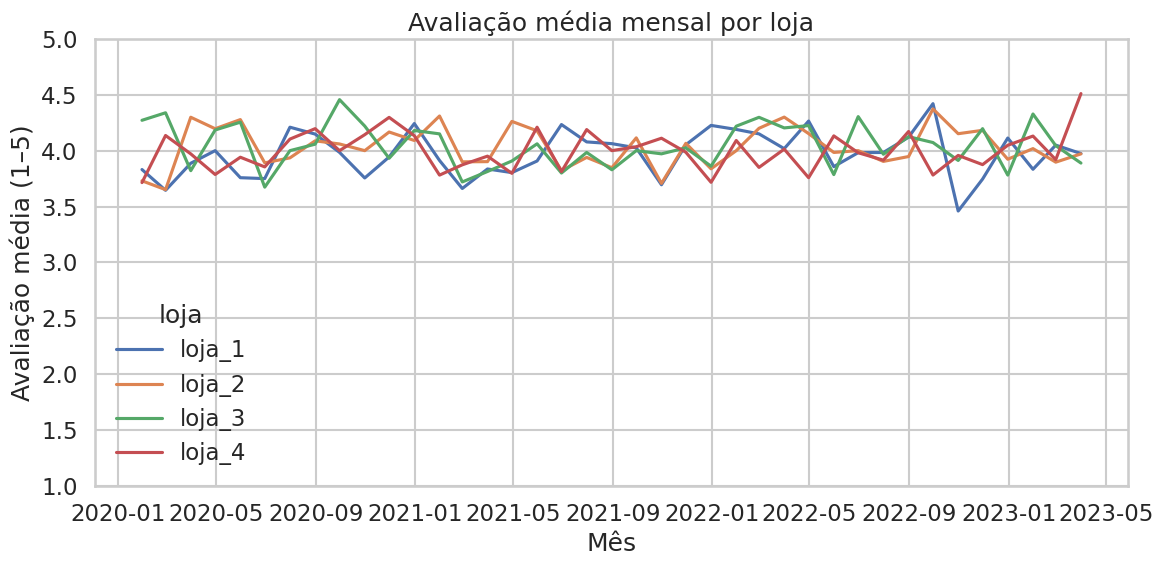

Sugestão objetiva: vender loja_2 (menor score no ranking multicritério).


In [61]:
# !pip install seaborn babel
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit  # opcional, usaremos np.polyfit
from babel.numbers import format_currency

# 1) Agregação mensal por loja (GMV, pedidos, frete, produto, avaliação)
monthly = (
    full.set_index("Data da Compra")
        .groupby("loja")
        .resample("M")
        .agg(
            gmv_cent=("receita_total_cent","sum"),
            pedidos=("Produto","size"),
            receita_frete_cent=("frete_cent","sum"),
            receita_produto_cent=("preco_cent","sum"),
            avaliacao_media=("Avaliação da compra","mean"),
        )
        .reset_index()
)
monthly["gmv_brl"] = monthly["gmv_cent"] / 100.0
monthly["frete_pct"] = (monthly["receita_frete_cent"] / monthly["gmv_cent"]).replace([np.inf, -np.inf], np.nan)
monthly["gmv_mm3"] = monthly.groupby("loja")["gmv_brl"].transform(lambda s: s.rolling(3, min_periods=1).mean())

# 2) Tendência (inclinação) do GMV por loja com regressão linear simples
def slope_trend(df):
    df = df.sort_values("Data da Compra")
    y = df["gmv_brl"].fillna(0).to_numpy()
    x = np.arange(len(y))
    if len(x) < 2:
        return np.nan
    m, b = np.polyfit(x, y, 1)
    return m

trend = (
    monthly.groupby("loja")
           .apply(slope_trend)
           .rename("slope_gmv")
           .reset_index()
)

# 3) Queda/alta percentual entre início e fim (usando média móvel 3M para robustez)
def pct_change_begin_end(df):
    df = df.sort_values("Data da Compra")
    start = df["gmv_mm3"].head(3).mean()
    end = df["gmv_mm3"].tail(3).mean()
    if pd.isna(start) or start == 0:
        return np.nan
    return (end - start) / start

chg = (
    monthly.groupby("loja")
           .apply(pct_change_begin_end)
           .rename("pct_change_gmv")
           .reset_index()
)

# 4) Métricas médias por loja: frete e avaliação
avg_frete = monthly.groupby("loja", as_index=False)["frete_pct"].mean(numeric_only=True).rename(columns={"frete_pct":"frete_pct_medio"})
avg_rate  = monthly.groupby("loja", as_index=False)["avaliacao_media"].mean(numeric_only=True).rename(columns={"avaliacao_media":"avaliacao_media_geral"})

# 5) Consolidar diagnóstico por loja
diag = trend.merge(chg, on="loja").merge(avg_frete, on="loja").merge(avg_rate, on="loja")

# 6) Score para decisão (pesos ajustáveis)
w_slope, w_chg, w_frete, w_rate = (-0.5, -0.3, -0.15, +0.05)  # negativo piora (slope/chg negativos), frete alto piora, avaliação alta melhora
diag["score"] = (
    w_slope * diag["slope_gmv"].fillna(0) +
    w_chg   * diag["pct_change_gmv"].fillna(0) +
    w_frete * diag["frete_pct_medio"].fillna(0) +
    w_rate  * diag["avaliacao_media_geral"].fillna(0)
)
diag = diag.sort_values("score")  # menor score = pior

candidata_venda = diag.iloc[0]["loja"]

# 7) Tabelas legíveis
def fmt_brl(v):
    return "" if pd.isna(v) else format_currency(v, "BRL", locale="pt_BR")

kpis_loja = (
    full.groupby("loja", as_index=False)
        .agg(
            pedidos=("Produto","size"),
            gmv_cent=("receita_total_cent","sum"),
            receita_produto_cent=("preco_cent","sum"),
            receita_frete_cent=("frete_cent","sum"),
        )
)
kpis_loja["gmv_brl"] = kpis_loja["gmv_cent"]/100
kpis_loja["receita_produto_brl"] = kpis_loja["receita_produto_cent"]/100
kpis_loja["receita_frete_brl"] = kpis_loja["receita_frete_cent"]/100
kpis_loja["frete_pct"] = (kpis_loja["receita_frete_cent"]/kpis_loja["gmv_cent"]).replace([np.inf, -np.inf], np.nan)

display(kpis_loja[["loja","pedidos","gmv_brl","receita_produto_brl","receita_frete_brl","frete_pct"]]
        .style.format({"gmv_brl": fmt_brl,"receita_produto_brl": fmt_brl,"receita_frete_brl": fmt_brl,"frete_pct":"{:.2%}"}))

display(diag.style.format({"slope_gmv":"{:+.2f}","pct_change_gmv":"{:+.2%}","frete_pct_medio":"{:.2%}","avaliacao_media_geral":"{:.2f}","score":"{:+.3f}"}))

# 8) Gráficos (sem pizza)
sns.set_theme(style="whitegrid", context="talk")

# 8.1 Linha: GMV mensal com média móvel (por loja, cores diferentes)
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly, x="Data da Compra", y="gmv_brl", hue="loja", alpha=0.35)
sns.lineplot(data=monthly, x="Data da Compra", y="gmv_mm3", hue="loja", linewidth=2.5, legend=False)
plt.title("GMV mensal e média móvel (3M) por loja")
plt.xlabel("Mês")
plt.ylabel("GMV (R$)")
plt.tight_layout()
plt.show()

# 8.2 Barras: GMV total por loja
plt.figure(figsize=(10,6))
totais = kpis_loja.sort_values("gmv_brl", ascending=False)
sns.barplot(data=totais, x="loja", y="gmv_brl", palette="viridis")
plt.title("GMV total por loja (período completo)")
plt.xlabel("Loja")
plt.ylabel("GMV (R$)")
plt.tight_layout()
plt.show()

# 8.3 Linha: participação do frete no GMV por loja ao longo do tempo
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly, x="Data da Compra", y="frete_pct", hue="loja")
plt.title("Participação do frete no GMV por loja (mensal)")
plt.xlabel("Mês")
plt.ylabel("Frete / GMV (%)")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda v, pos: f"{v*100:.0f}%"))
plt.tight_layout()
plt.show()

# 8.4 Linha: avaliação média mensal por loja
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly, x="Data da Compra", y="avaliacao_media", hue="loja")
plt.title("Avaliação média mensal por loja")
plt.xlabel("Mês")
plt.ylabel("Avaliação média (1–5)")
plt.ylim(1,5)
plt.tight_layout()
plt.show()

print(f"Sugestão objetiva: vender {candidata_venda} (menor score no ranking multicritério).")


/tmp/ipython-input-1343776116.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipython-input-1343776116.py:116: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pct_change_begin_end)


Sugestão objetiva: vender loja_4 (pior no ranking multicritério).


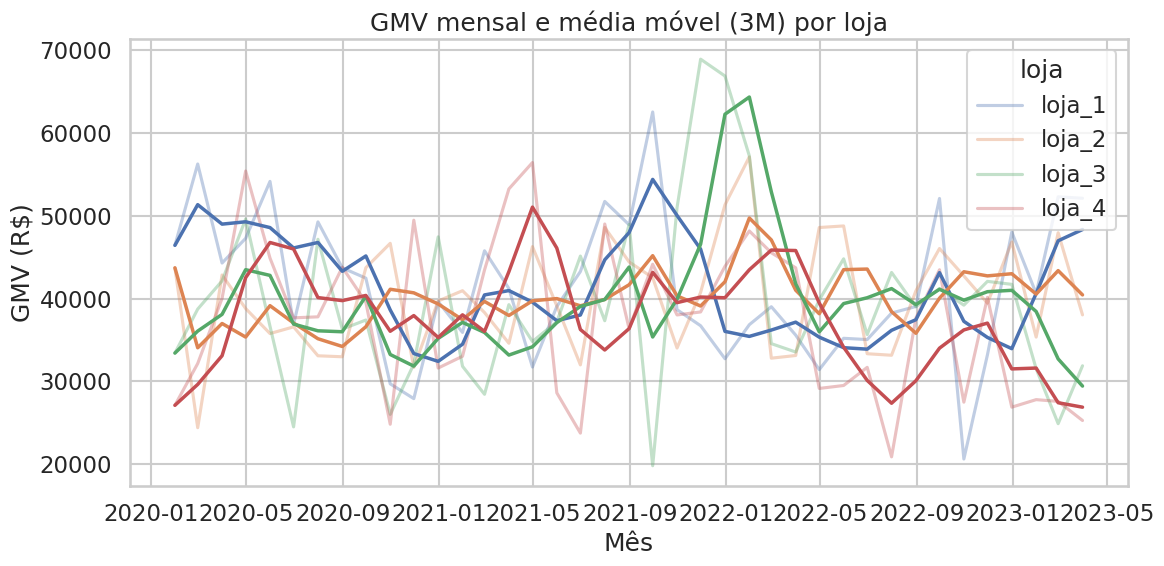

/tmp/ipython-input-1343776116.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=kpis_loja.sort_values("gmv_brl", ascending=False), x="loja", y="gmv_brl", palette="viridis", errorbar=None)


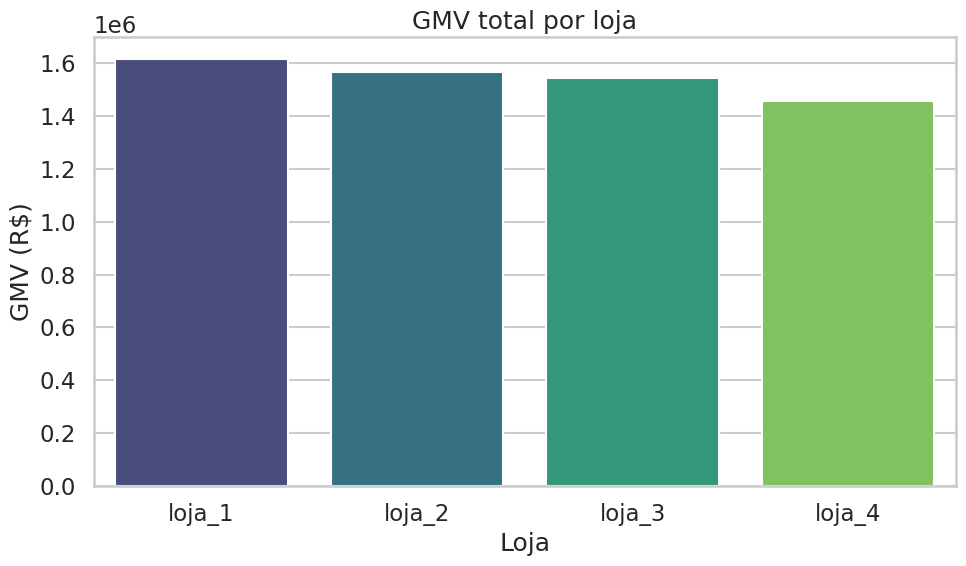

/tmp/ipython-input-1343776116.py:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=kpis_loja.sort_values("frete_medio", ascending=False), x="loja", y="frete_medio", palette="mako", errorbar=None)


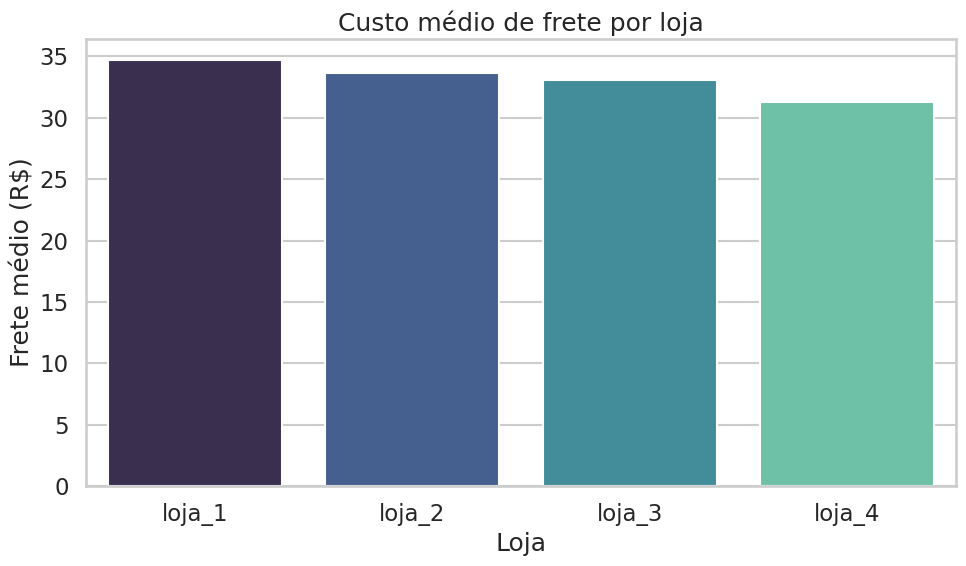

/tmp/ipython-input-1343776116.py:177: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=kpis_loja.sort_values("avaliacao_media"), x="loja", y="avaliacao_media", palette="crest", errorbar=None)


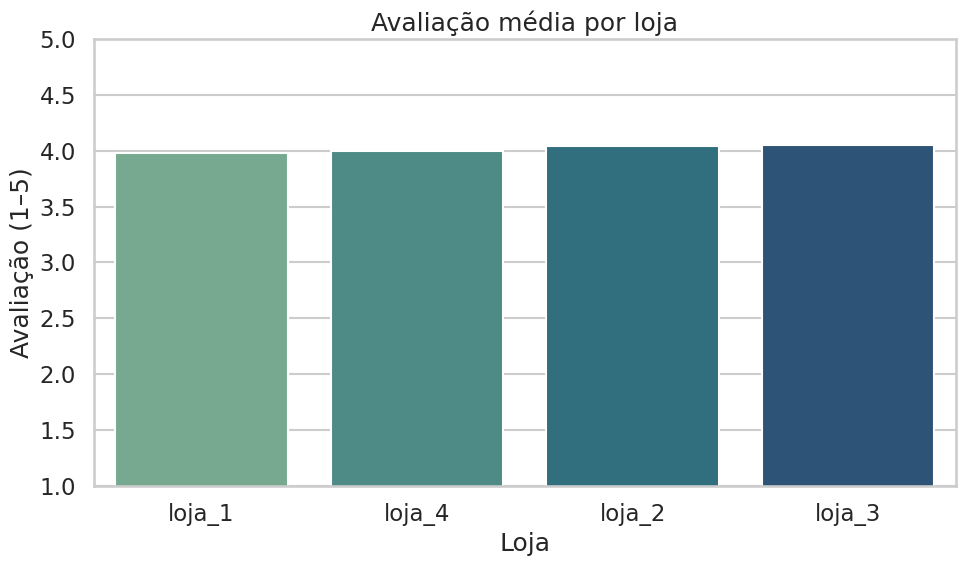

/tmp/ipython-input-1343776116.py:182: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


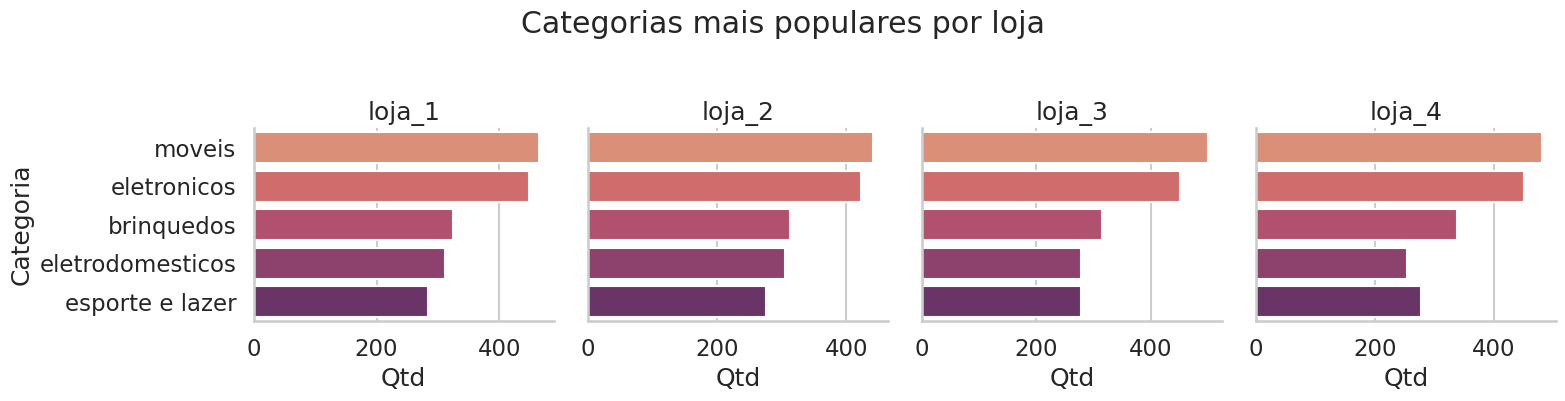

/tmp/ipython-input-1343776116.py:193: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_.sort_values("qtd"), x="qtd", y="Produto", palette="rocket", errorbar=None)


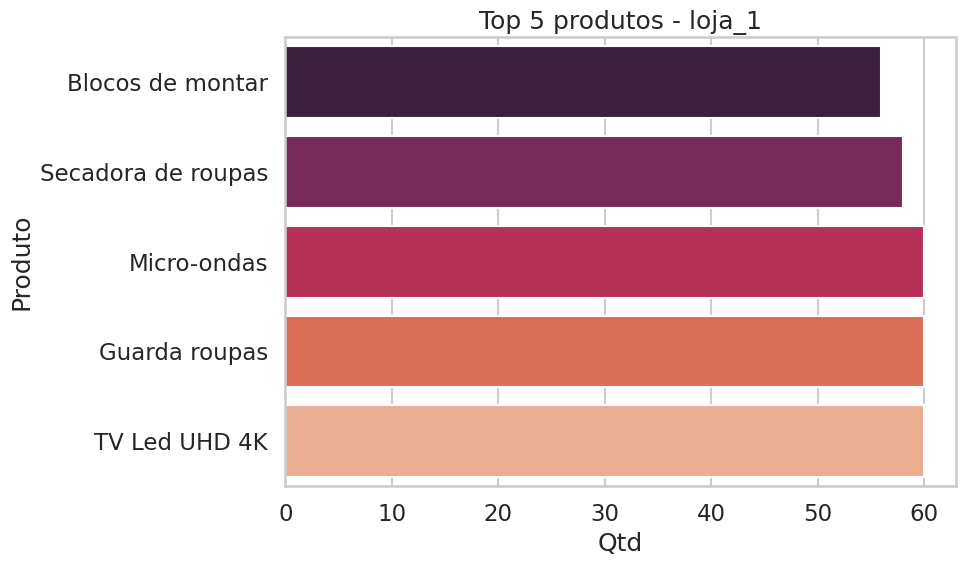

/tmp/ipython-input-1343776116.py:193: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_.sort_values("qtd"), x="qtd", y="Produto", palette="rocket", errorbar=None)


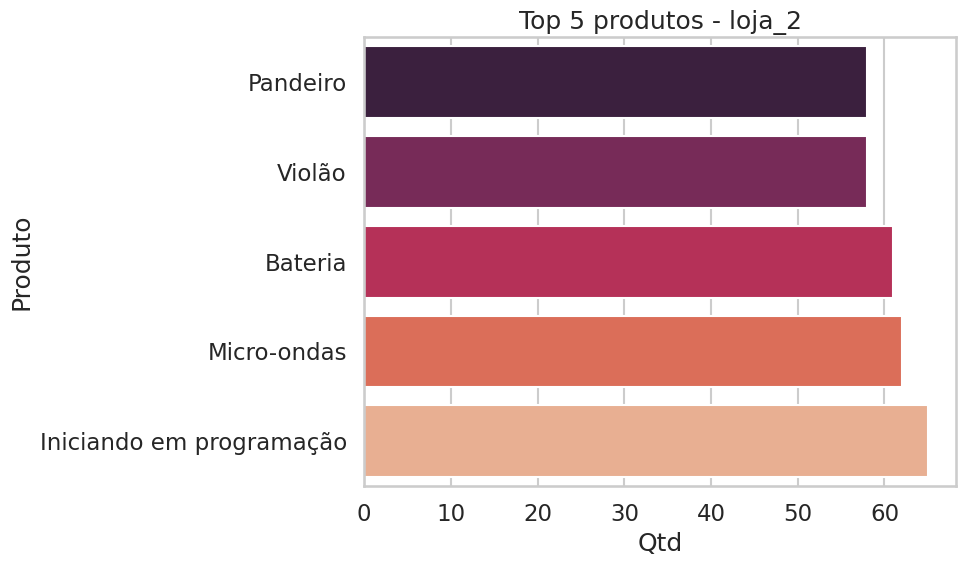

/tmp/ipython-input-1343776116.py:193: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_.sort_values("qtd"), x="qtd", y="Produto", palette="rocket", errorbar=None)


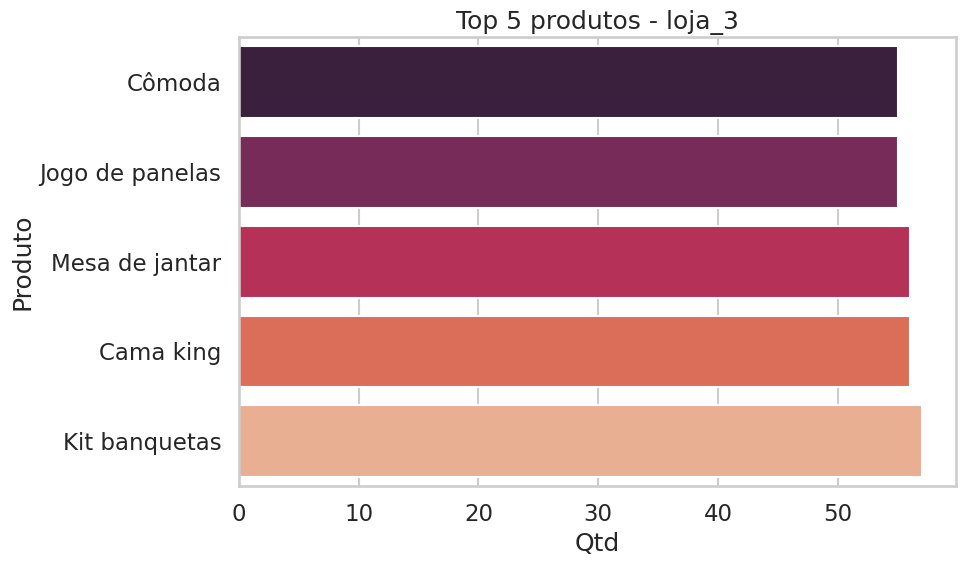

/tmp/ipython-input-1343776116.py:193: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_.sort_values("qtd"), x="qtd", y="Produto", palette="rocket", errorbar=None)


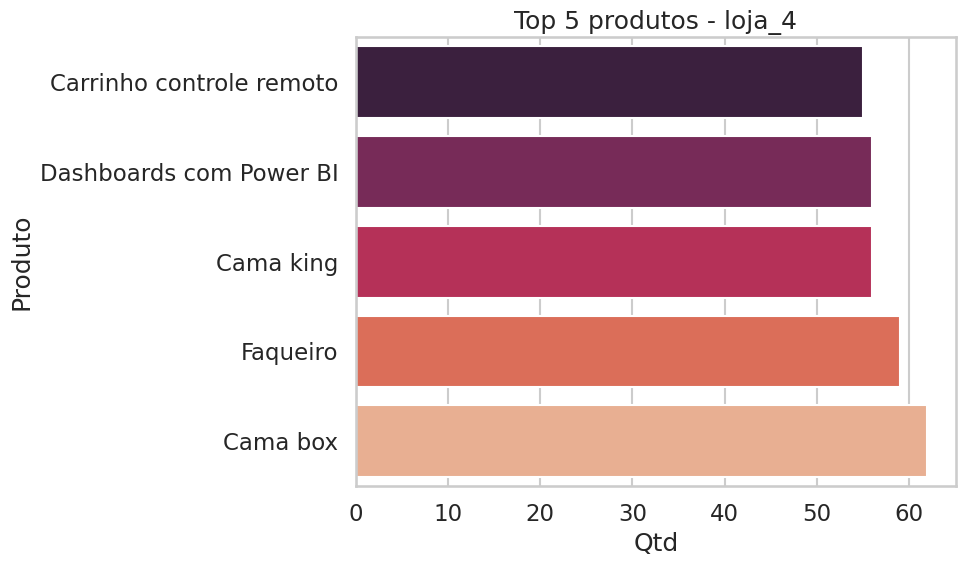

/tmp/ipython-input-1343776116.py:199: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_.sort_values("qtd"), x="qtd", y="Produto", palette="light:#5A9", errorbar=None)


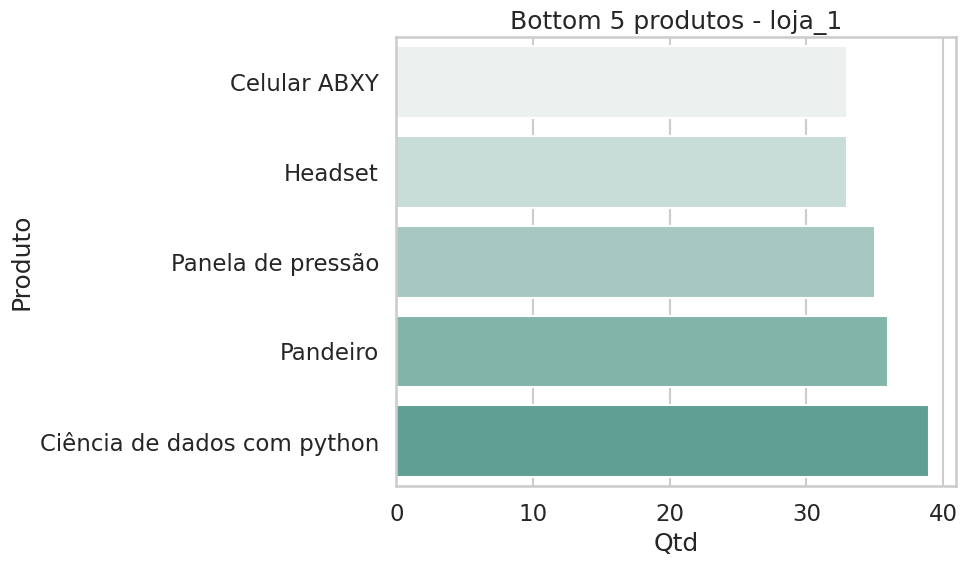

/tmp/ipython-input-1343776116.py:199: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_.sort_values("qtd"), x="qtd", y="Produto", palette="light:#5A9", errorbar=None)


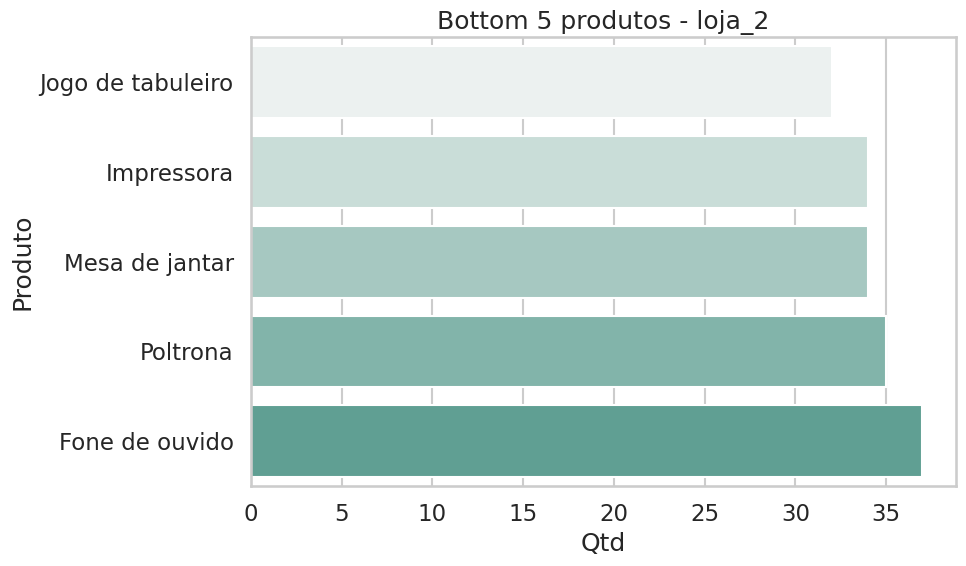

/tmp/ipython-input-1343776116.py:199: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_.sort_values("qtd"), x="qtd", y="Produto", palette="light:#5A9", errorbar=None)


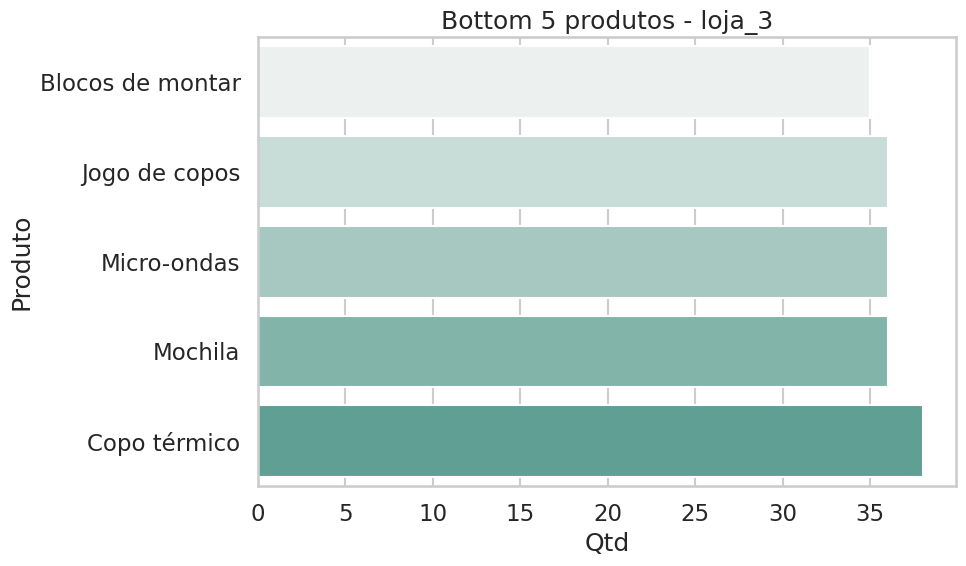

/tmp/ipython-input-1343776116.py:199: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_.sort_values("qtd"), x="qtd", y="Produto", palette="light:#5A9", errorbar=None)


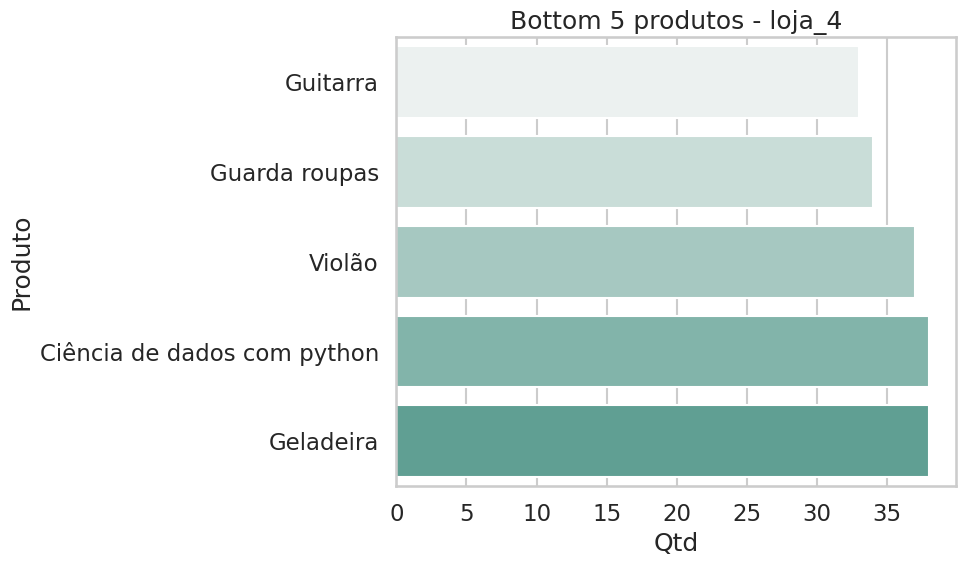

In [53]:
# !pip install seaborn babel
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_HALF_UP
from babel.numbers import format_currency

# -----------------------------
# 1) Entrada: URLs e colunas
# -----------------------------
urls_lojas = {
    'loja_1': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_1.csv",
    'loja_2': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_2.csv",
    'loja_3': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_3.csv",
    'loja_4': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_4.csv"
}

COLS = [
    "Produto","Categoria do Produto","Preço","Frete","Data da Compra",
    "Vendedor","Local da compra","Avaliação da compra","Tipo de pagamento",
    "Quantidade de parcelas","lat","lon"
]

def to_cents(x):
    if pd.isna(x): return 0
    d = Decimal(str(x)).quantize(Decimal("0.01"), rounding=ROUND_HALF_UP)
    return int(d * 100)

def carregar_normalizar(nome_loja, url):
    df = pd.read_csv(url, encoding="utf-8")
    df = df[COLS]
    df["Data da Compra"] = pd.to_datetime(df["Data da Compra"], format="%d/%m/%Y", errors="coerce")
    df["Preço"] = pd.to_numeric(df["Preço"], errors="coerce")
    df["Frete"] = pd.to_numeric(df["Frete"], errors="coerce")
    for c in ["Produto","Categoria do Produto","Vendedor","Local da compra","Tipo de pagamento"]:
        df[c] = df[c].astype("string").str.strip()
    # centavos para somas exatas
    df["preco_cent"] = df["Preço"].apply(to_cents)
    df["frete_cent"] = df["Frete"].apply(to_cents)
    df["gmv_cent"]   = df["preco_cent"] + df["frete_cent"]
    df["loja"] = nome_loja
    return df

dfs = [carregar_normalizar(loja, url) for loja, url in urls_lojas.items()]
full = pd.concat(dfs, ignore_index=True)

# -----------------------------
# 2) Métricas por loja
# -----------------------------
kpis_loja = (
    full.groupby("loja", as_index=False)
        .agg(
            pedidos=("Produto","size"),
            gmv_cent=("gmv_cent","sum"),
            receita_produtos=("Preço","sum"),
            receita_frete=("Frete","sum"),
            frete_medio=("Frete","mean"),
            avaliacao_media=("Avaliação da compra","mean"),
        )
)
kpis_loja["gmv_brl"] = kpis_loja["gmv_cent"]/100
kpis_loja["frete_pct"] = (kpis_loja["receita_frete"] / (kpis_loja["receita_produtos"] + kpis_loja["receita_frete"])).replace([np.inf,-np.inf], np.nan)

# Categorias mais populares (Top N por loja)
N_TOP = 5
cats_top = (
    full.groupby(["loja","Categoria do Produto"])["Produto"]
        .size()
        .reset_index(name="qtd")
        .sort_values(["loja","qtd"], ascending=[True, False])
        .groupby("loja")
        .head(N_TOP)
)

# Produtos mais e menos vendidos por loja
prod_counts = (
    full.groupby(["loja","Produto"])["Produto"]
        .size()
        .rename("qtd")
        .reset_index()
)
prods_top = prod_counts.sort_values(["loja","qtd"], ascending=[True, False]).groupby("loja").head(N_TOP)
prods_bottom = prod_counts.sort_values(["loja","qtd"], ascending=[True, True]).groupby("loja").head(N_TOP)

# -----------------------------
# 3) Séries temporais (mensal)
# -----------------------------
monthly = (
    full.set_index("Data da Compra")
        .groupby("loja")
        .resample("M")
        .agg(
            gmv_cent=("gmv_cent","sum"),
            pedidos=("Produto","size"),
            receita_frete_cent=("frete_cent","sum"),
            avaliacao_media=("Avaliação da compra","mean"),
        )
        .reset_index()
)
monthly["gmv_brl"] = monthly["gmv_cent"]/100
monthly["frete_pct"] = (monthly["receita_frete_cent"]/monthly["gmv_cent"]).replace([np.inf,-np.inf], np.nan)
monthly["gmv_mm3"] = monthly.groupby("loja")["gmv_brl"].transform(lambda s: s.rolling(3, min_periods=1).mean())

# Crescimento entre início e fim (média móvel 3M para robustez)
def pct_change_begin_end(df):
    df = df.sort_values("Data da Compra")
    start = df["gmv_mm3"].head(3).mean()
    end   = df["gmv_mm3"].tail(3).mean()
    if pd.isna(start) or start == 0:
        return np.nan
    return (end - start) / start

crescimento = (
    monthly.groupby("loja")
           .apply(pct_change_begin_end)
           .rename("crescimento_pct")
           .reset_index()
)

# -----------------------------
# 4) Score de decisão (qual vender)
# -----------------------------
# Regras: pior = menor GMV, menor avaliação, maior frete médio, menor crescimento
m = kpis_loja.merge(crescimento, on="loja", how="left")
# normalização min-max por métrica
def minmax(s):
    s = s.astype(float)
    if s.nunique(dropna=True) <= 1:
        return pd.Series(np.zeros(len(s)), index=s.index)
    return (s - s.min()) / (s.max() - s.min())

gmv_norm     = minmax(m["gmv_brl"])
rate_norm    = minmax(m["avaliacao_media"])
frete_norm   = minmax(m["frete_medio"])
cres_norm    = minmax(m["crescimento_pct"].fillna(0))

# score: 0 pior/1 melhor por métrica, depois inverter onde for necessário e ponderar
score = (
    0.40*(1 - gmv_norm) +        # menor GMV pior
    0.30*(1 - rate_norm) +       # menor avaliação pior
    0.20*(frete_norm) +          # frete médio mais alto pior
    0.10*(1 - cres_norm)         # menor crescimento pior
)
m["sell_score"] = score
m = m.sort_values("sell_score", ascending=False)
candidata_venda = m.iloc[0]["loja"]
print(f"Sugestão objetiva: vender {candidata_venda} (pior no ranking multicritério).")

# -----------------------------
# 5) Gráficos (sem pizza)
# -----------------------------
sns.set_theme(style="whitegrid", context="talk")

# 5.1 Linha: GMV mensal e média móvel 3M por loja
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly, x="Data da Compra", y="gmv_brl", hue="loja", alpha=0.35)
sns.lineplot(data=monthly, x="Data da Compra", y="gmv_mm3", hue="loja", legend=False, linewidth=2.5)
plt.title("GMV mensal e média móvel (3M) por loja")
plt.xlabel("Mês"); plt.ylabel("GMV (R$)")
plt.tight_layout(); plt.show()

# 5.2 Barras: GMV total por loja
plt.figure(figsize=(10,6))
sns.barplot(data=kpis_loja.sort_values("gmv_brl", ascending=False), x="loja", y="gmv_brl", palette="viridis", errorbar=None)
plt.title("GMV total por loja"); plt.xlabel("Loja"); plt.ylabel("GMV (R$)")
plt.tight_layout(); plt.show()

# 5.3 Barras: Frete médio por loja
plt.figure(figsize=(10,6))
sns.barplot(data=kpis_loja.sort_values("frete_medio", ascending=False), x="loja", y="frete_medio", palette="mako", errorbar=None)
plt.title("Custo médio de frete por loja"); plt.xlabel("Loja"); plt.ylabel("Frete médio (R$)")
plt.tight_layout(); plt.show()

# 5.4 Barras: Avaliação média por loja
plt.figure(figsize=(10,6))
sns.barplot(data=kpis_loja.sort_values("avaliacao_media"), x="loja", y="avaliacao_media", palette="crest", errorbar=None)
plt.title("Avaliação média por loja"); plt.xlabel("Loja"); plt.ylabel("Avaliação (1–5)")
plt.ylim(1,5); plt.tight_layout(); plt.show()

# 5.5 Barras horizontais: Top categorias por loja
g = sns.catplot(
    data=cats_top.sort_values(["loja","qtd"], ascending=[True, False]),
    kind="bar", x="qtd", y="Categoria do Produto", col="loja", sharex=False, height=4, aspect=1.0, palette="flare", errorbar=None
)
g.set_titles("{col_name}"); g.set_xlabels("Qtd"); g.set_ylabels("Categoria")
plt.suptitle("Categorias mais populares por loja", y=1.02)
plt.tight_layout(); plt.show()

# 5.6 Barras horizontais: Top e Bottom produtos por loja (exemplo para uma loja)
for nome, df_ in prods_top.groupby("loja"):
    plt.figure(figsize=(10,6))
    sns.barplot(data=df_.sort_values("qtd"), x="qtd", y="Produto", palette="rocket", errorbar=None)
    plt.title(f"Top {N_TOP} produtos - {nome}"); plt.xlabel("Qtd"); plt.ylabel("Produto")
    plt.tight_layout(); plt.show()

for nome, df_ in prods_bottom.groupby("loja"):
    plt.figure(figsize=(10,6))
    sns.barplot(data=df_.sort_values("qtd"), x="qtd", y="Produto", palette="light:#5A9", errorbar=None)
    plt.title(f"Bottom {N_TOP} produtos - {nome}"); plt.xlabel("Qtd"); plt.ylabel("Produto")
    plt.tight_layout(); plt.show()


/tmp/ipython-input-1143073427.py:75: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipython-input-1143073427.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend = monthly.groupby("loja").apply(slope_trend).rename("slope_gmv").reset_index()
/tmp/ipython-input-1143073427.py:105: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cresc

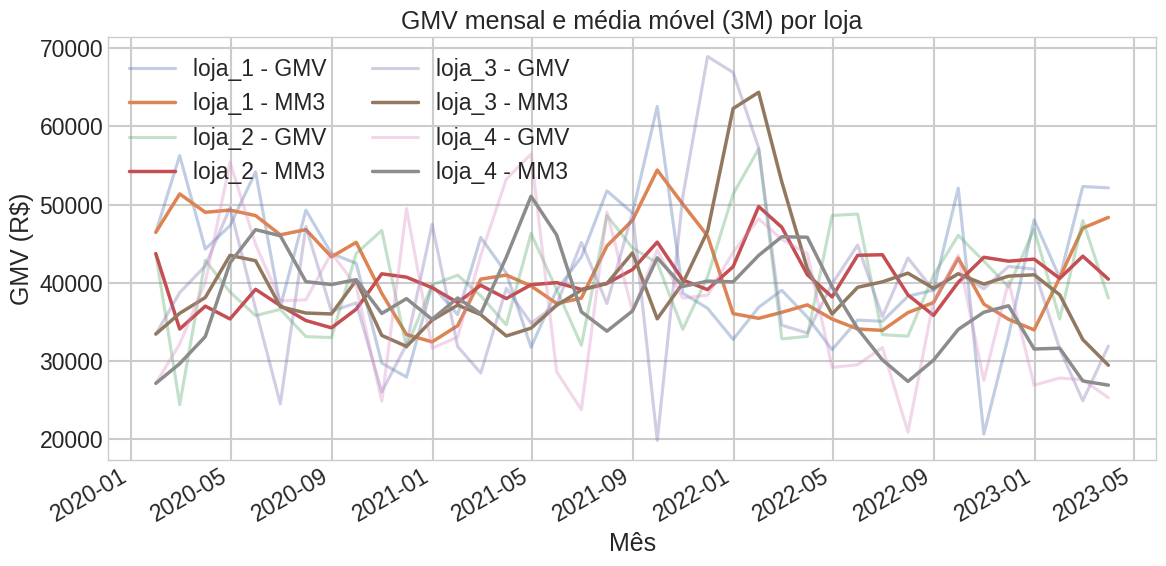

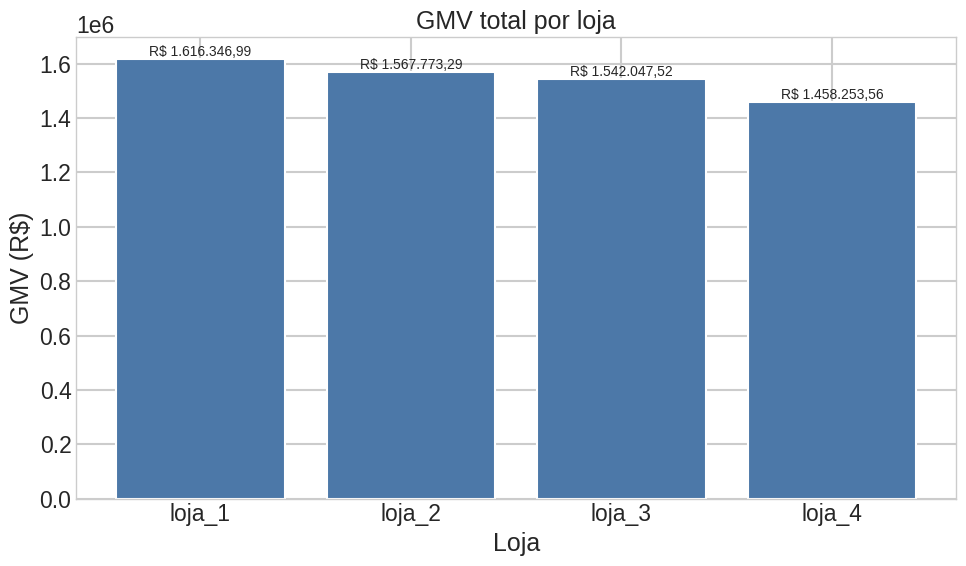

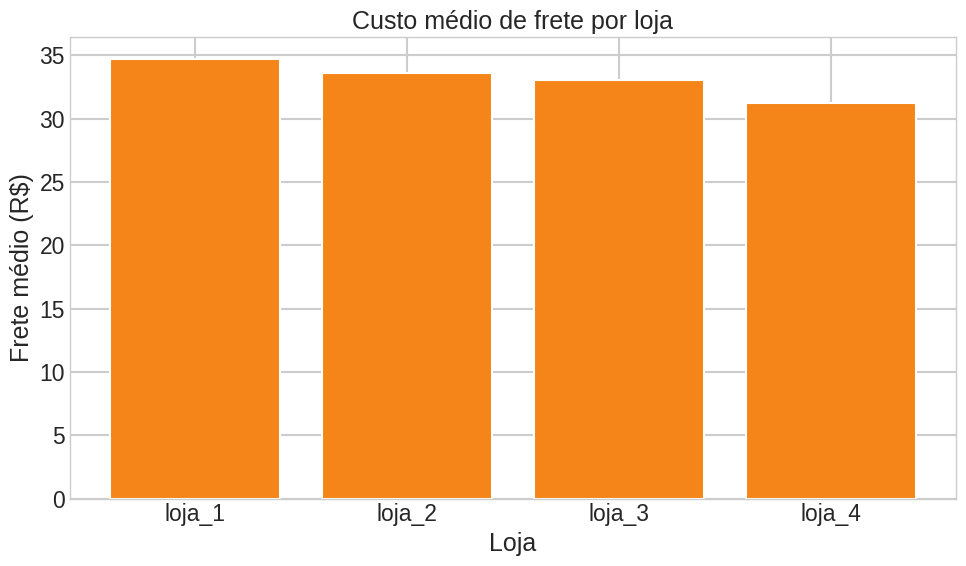

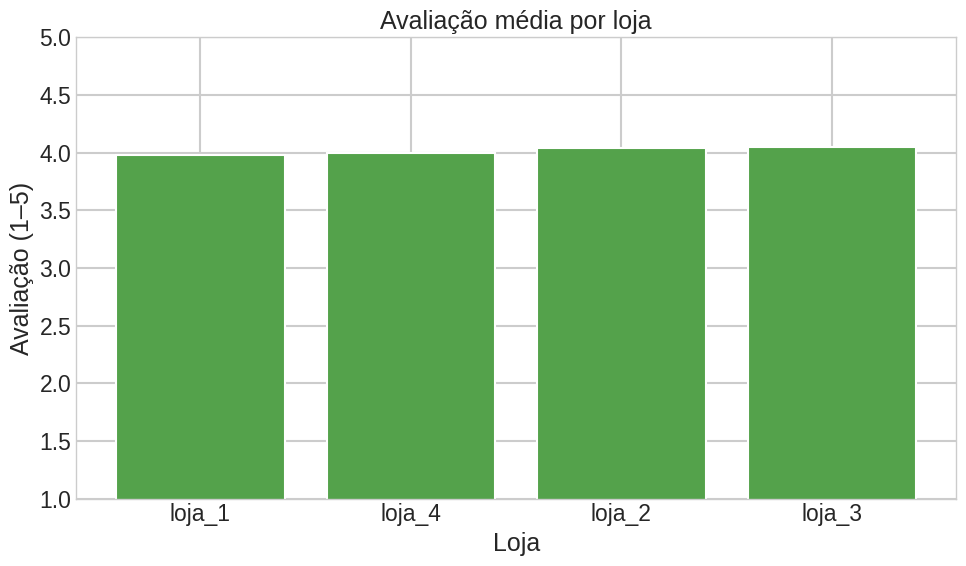

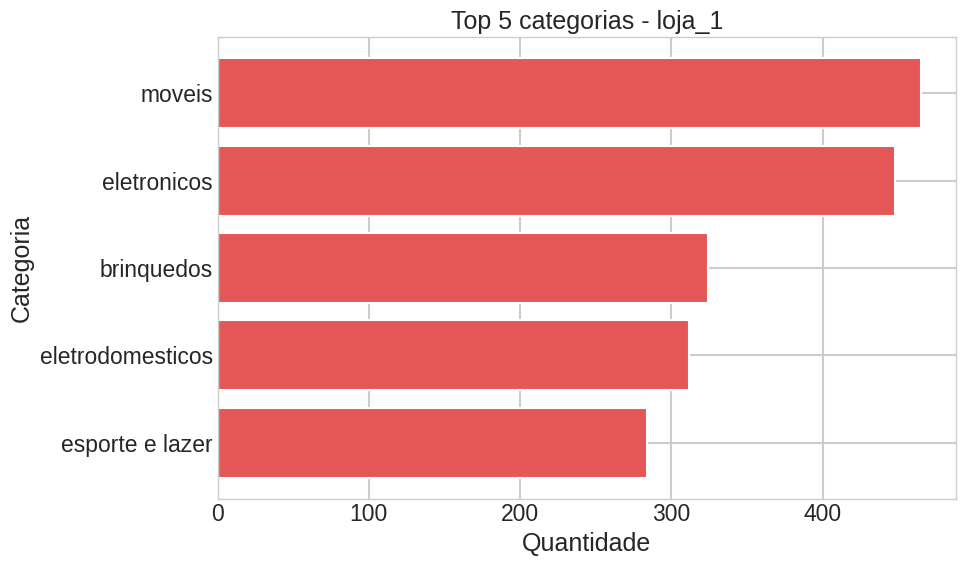

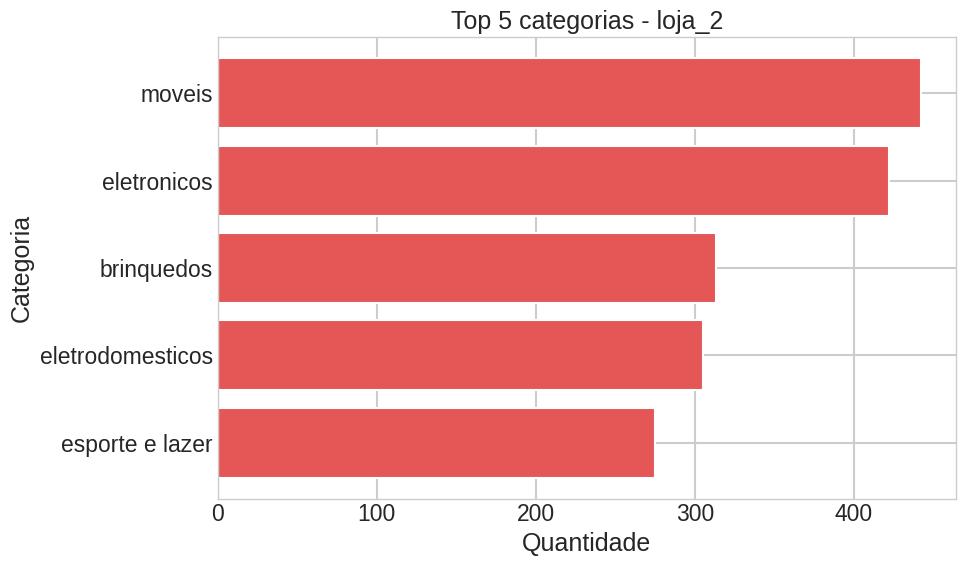

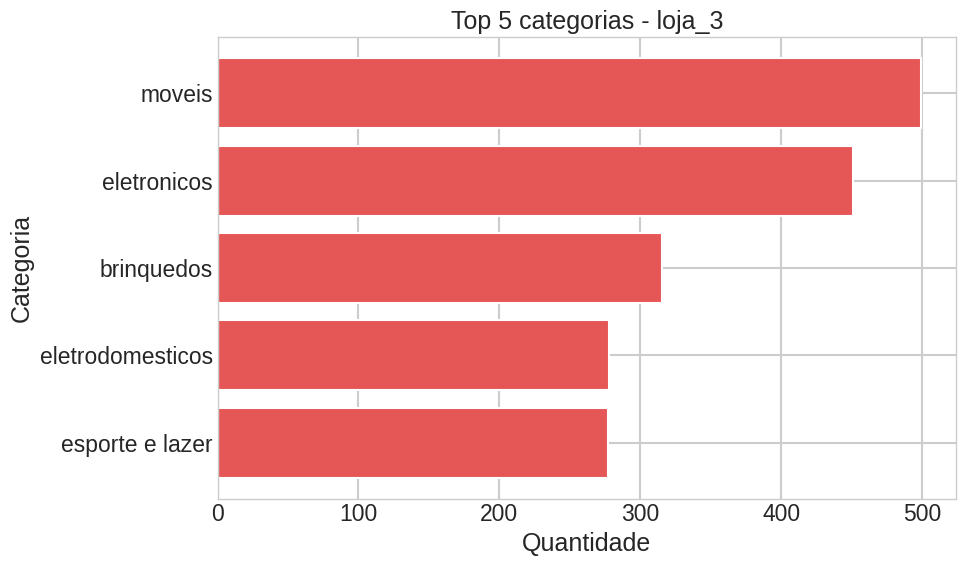

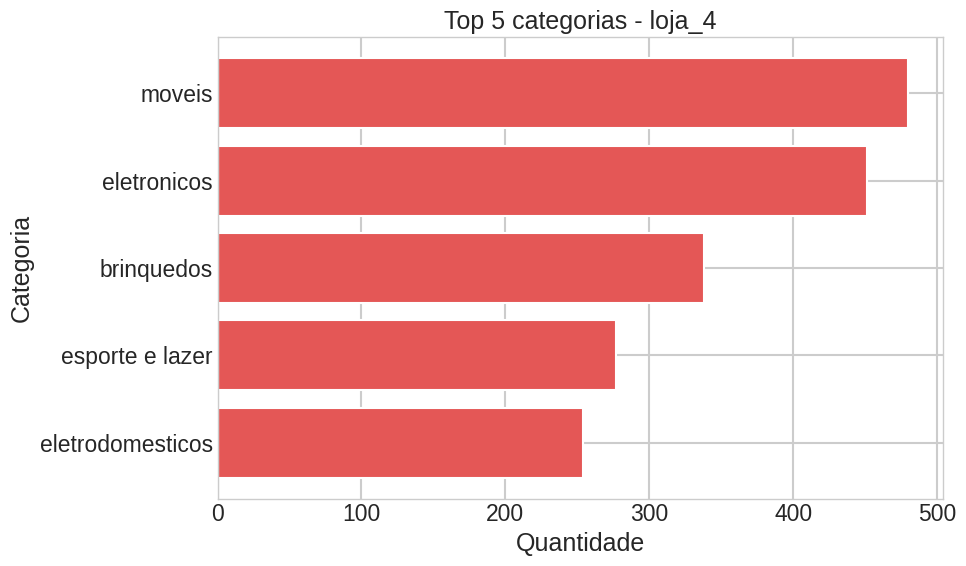

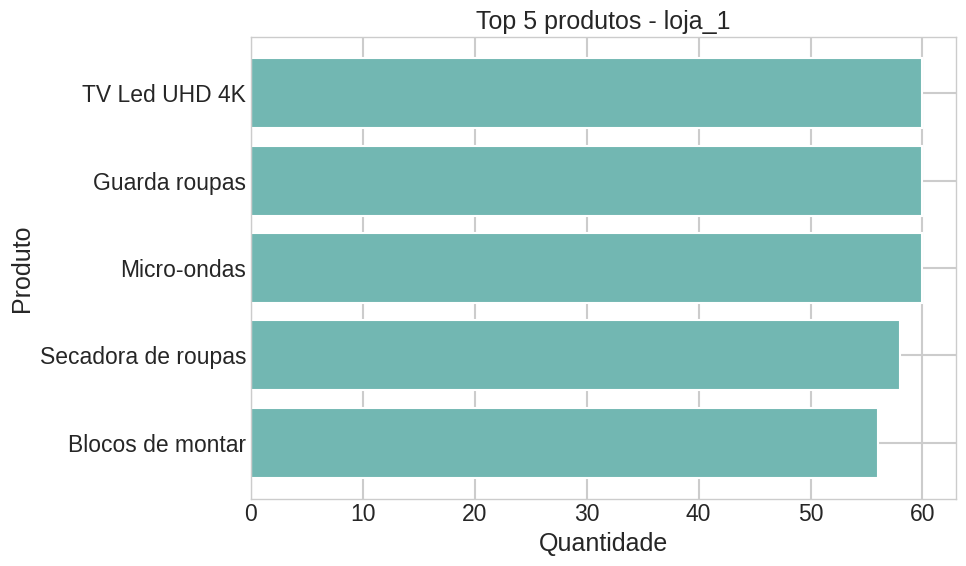

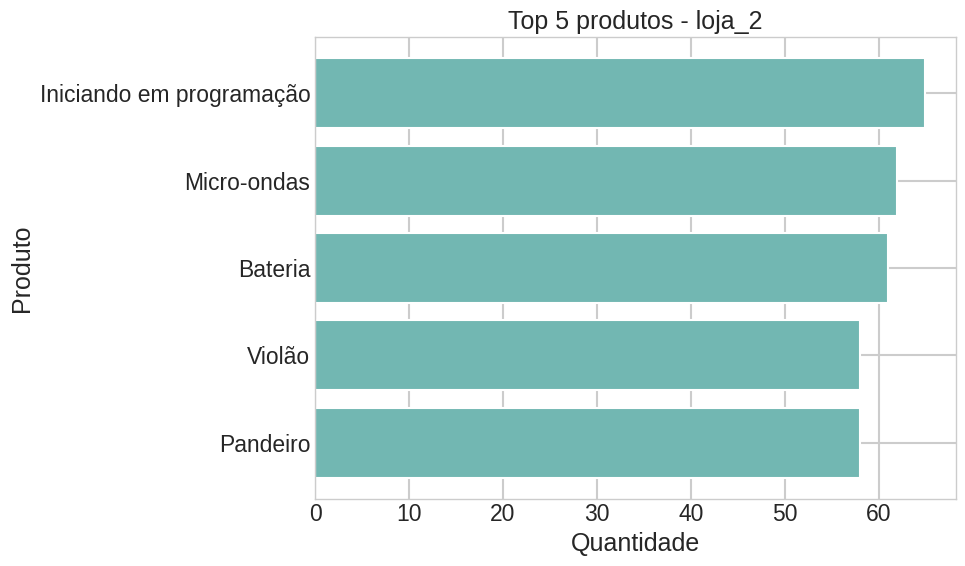

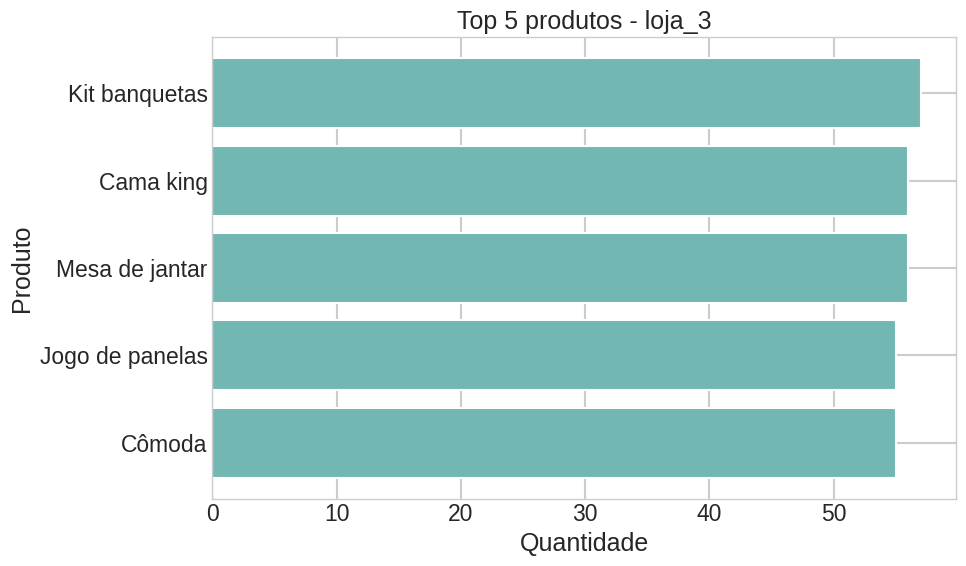

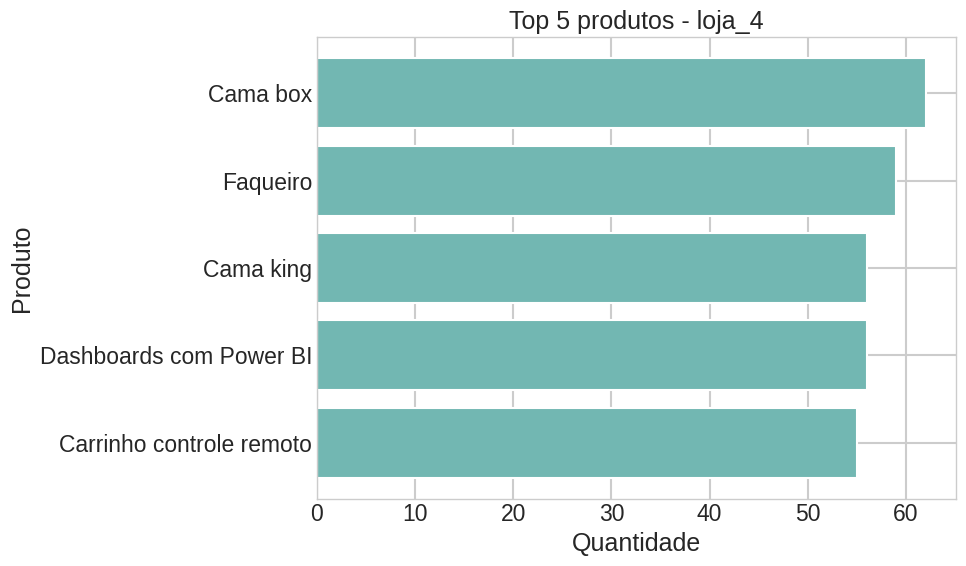

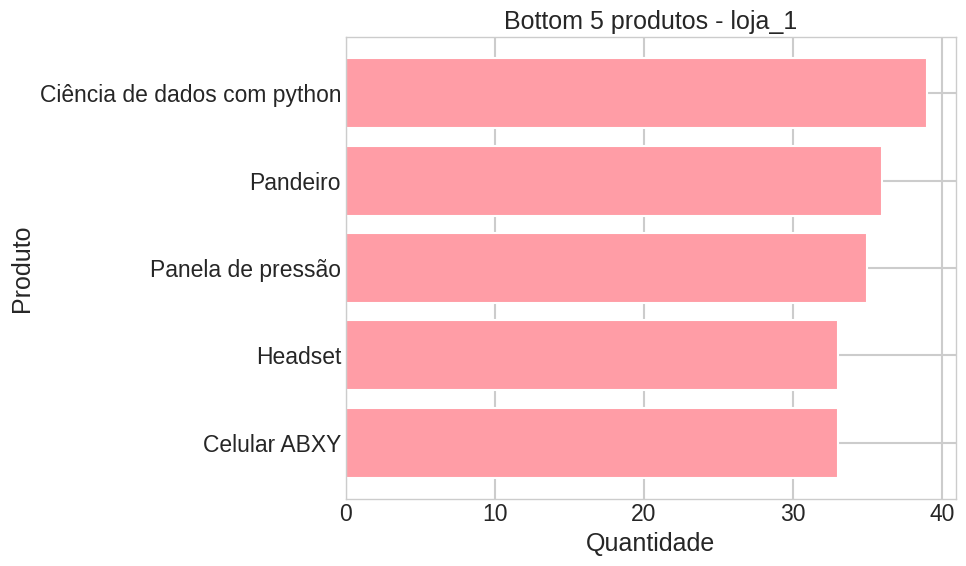

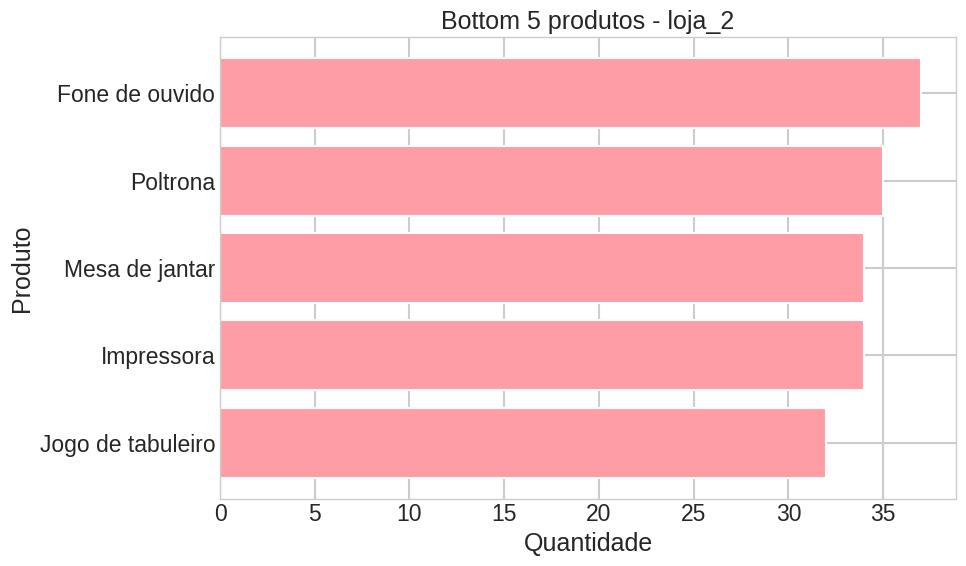

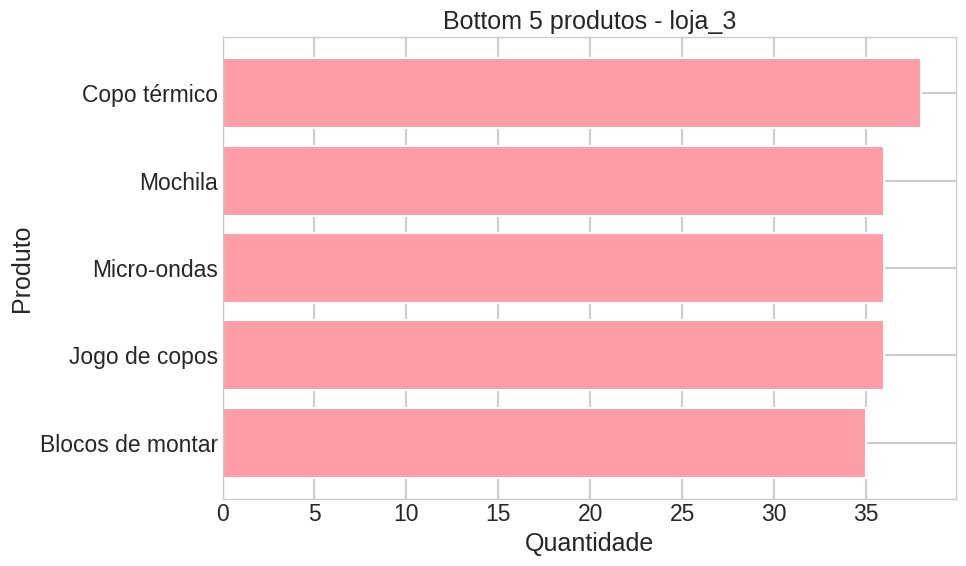

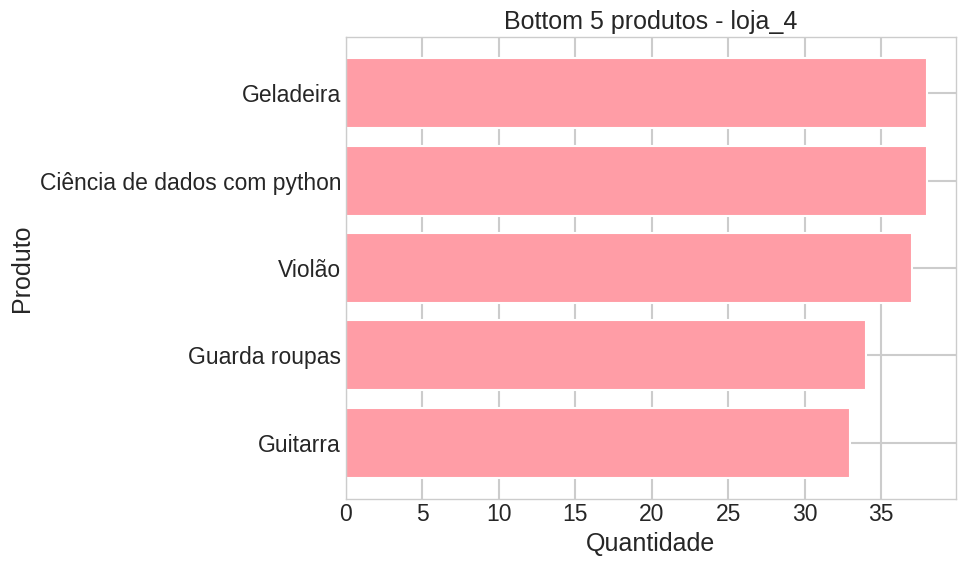

A loja a ser vendida é "loja_4".


In [62]:
# !pip install babel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_HALF_UP
from babel.numbers import format_currency

# 1) Entrada: URLs
urls_lojas = {
    'loja_1': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_1.csv",
    'loja_2': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_2.csv",
    'loja_3': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_3.csv",
    'loja_4': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_4.csv"
}
COLS = ["Produto","Categoria do Produto","Preço","Frete","Data da Compra",
        "Vendedor","Local da compra","Avaliação da compra","Tipo de pagamento",
        "Quantidade de parcelas","lat","lon"]

def to_cents(x):
    if pd.isna(x): return 0
    d = Decimal(str(x)).quantize(Decimal("0.01"), rounding=ROUND_HALF_UP)
    return int(d * 100)

def carregar_normalizar(nome_loja, url):
    df = pd.read_csv(url, encoding="utf-8")
    df = df[COLS]
    df["Data da Compra"] = pd.to_datetime(df["Data da Compra"], format="%d/%m/%Y", errors="coerce")
    df["Preço"] = pd.to_numeric(df["Preço"], errors="coerce")
    df["Frete"] = pd.to_numeric(df["Frete"], errors="coerce")
    for c in ["Produto","Categoria do Produto","Vendedor","Local da compra","Tipo de pagamento"]:
        df[c] = df[c].astype("string").str.strip()
    df["preco_cent"] = df["Preço"].apply(to_cents)
    df["frete_cent"] = df["Frete"].apply(to_cents)
    df["gmv_cent"]   = df["preco_cent"] + df["frete_cent"]
    df["loja"] = nome_loja
    return df

dfs = [carregar_normalizar(loja, url) for loja, url in urls_lojas.items()]
full = pd.concat(dfs, ignore_index=True).dropna(subset=["Data da Compra"])

# 2) KPIs por loja
kpis = (
    full.groupby("loja", as_index=False)
        .agg(
            pedidos=("Produto","size"),
            gmv_cent=("gmv_cent","sum"),
            receita_produtos=("Preço","sum"),
            receita_frete=("Frete","sum"),
            frete_medio=("Frete","mean"),
            avaliacao_media=("Avaliação da compra","mean"),
        )
)
kpis["gmv_brl"] = kpis["gmv_cent"]/100
kpis["frete_pct"] = (kpis["receita_frete"] / (kpis["receita_produtos"] + kpis["receita_frete"])).replace([np.inf,-np.inf], np.nan)

# 3) Categorias e produtos
N_TOP = 5
cats_top = (
    full.groupby(["loja","Categoria do Produto"])["Produto"]
        .size().reset_index(name="qtd")
        .sort_values(["loja","qtd"], ascending=[True, False])
        .groupby("loja").head(N_TOP)
)
prod_counts = (
    full.groupby(["loja","Produto"])["Produto"]
        .size().rename("qtd").reset_index()
)
prods_top = prod_counts.sort_values(["loja","qtd"], ascending=[True, False]).groupby("loja").head(N_TOP)
prods_bottom = prod_counts.sort_values(["loja","qtd"], ascending=[True, True]).groupby("loja").head(N_TOP)

# 4) Séries temporais mensais
monthly = (
    full.set_index("Data da Compra")
        .groupby("loja")
        .resample("M")
        .agg(
            gmv_cent=("gmv_cent","sum"),
            pedidos=("Produto","size"),
            receita_frete_cent=("frete_cent","sum"),
            avaliacao_media=("Avaliação da compra","mean"),
        )
        .reset_index()
)
monthly["gmv_brl"] = monthly["gmv_cent"]/100
monthly["frete_pct"] = (monthly["receita_frete_cent"]/monthly["gmv_cent"]).replace([np.inf,-np.inf], np.nan)
monthly["gmv_mm3"] = monthly.groupby("loja")["gmv_brl"].transform(lambda s: s.rolling(3, min_periods=1).mean())

def slope_trend(df):
    df = df.sort_values("Data da Compra")
    y = df["gmv_brl"].fillna(0).to_numpy()
    x = np.arange(len(y))
    if len(x) < 2: return np.nan
    m, b = np.polyfit(x, y, 1)
    return m

trend = monthly.groupby("loja").apply(slope_trend).rename("slope_gmv").reset_index()

def pct_change_begin_end(df):
    df = df.sort_values("Data da Compra")
    start = df["gmv_mm3"].head(3).mean()
    end   = df["gmv_mm3"].tail(3).mean()
    if pd.isna(start) or start == 0: return np.nan
    return (end - start) / start

crescimento = monthly.groupby("loja").apply(pct_change_begin_end).rename("crescimento_pct").reset_index()

# 5) Score de decisão (qual vender)
m = kpis.merge(crescimento, on="loja", how="left").merge(trend, on="loja", how="left")
def minmax(s):
    s = s.astype(float)
    if s.nunique(dropna=True) <= 1: return pd.Series(np.zeros(len(s)), index=s.index)
    return (s - s.min()) / (s.max() - s.min())

gmv_norm   = minmax(m["gmv_brl"])
rate_norm  = minmax(m["avaliacao_media"])
frete_norm = minmax(m["frete_medio"])
cres_norm  = minmax(m["crescimento_pct"].fillna(0))

m["sell_score"] = 0.40*(1 - gmv_norm) + 0.30*(1 - rate_norm) + 0.20*(frete_norm) + 0.10*(1 - cres_norm)
m = m.sort_values("sell_score", ascending=False)
candidata_venda = m.iloc[0]["loja"]

# 6) Gráficos (Matplotlib puro)
plt.style.use("seaborn-v0_8-whitegrid")  # apenas estilo visual

# 6.1 Linha: GMV mensal e média móvel por loja
plt.figure(figsize=(12,6))
for loja, df_ in monthly.groupby("loja"):
    df_ = df_.sort_values("Data da Compra")
    plt.plot(df_["Data da Compra"], df_["gmv_brl"], alpha=0.35, label=f"{loja} - GMV")
    plt.plot(df_["Data da Compra"], df_["gmv_mm3"], linewidth=2.5, label=f"{loja} - MM3")
plt.title("GMV mensal e média móvel (3M) por loja")
plt.xlabel("Mês"); plt.ylabel("GMV (R$)")
plt.legend(ncols=2); plt.gcf().autofmt_xdate(); plt.tight_layout(); plt.show()

# 6.2 Barras: GMV total por loja
plt.figure(figsize=(10,6))
ordem = kpis.sort_values("gmv_brl", ascending=False)
plt.bar(ordem["loja"], ordem["gmv_brl"], color="#4c78a8")
plt.title("GMV total por loja"); plt.xlabel("Loja"); plt.ylabel("GMV (R$)")
for i, v in enumerate(ordem["gmv_brl"]):
    plt.text(i, v, format_currency(v, "BRL", locale="pt_BR"), ha="center", va="bottom", fontsize=10, rotation=0)
plt.tight_layout(); plt.show()

# 6.3 Barras: Frete médio por loja
plt.figure(figsize=(10,6))
ordem2 = kpis.sort_values("frete_medio", ascending=False)
plt.bar(ordem2["loja"], ordem2["frete_medio"], color="#f58518")
plt.title("Custo médio de frete por loja"); plt.xlabel("Loja"); plt.ylabel("Frete médio (R$)")
plt.tight_layout(); plt.show()

# 6.4 Barras: Avaliação média por loja
plt.figure(figsize=(10,6))
ordem3 = kpis.sort_values("avaliacao_media")
plt.bar(ordem3["loja"], ordem3["avaliacao_media"], color="#54a24b")
plt.title("Avaliação média por loja"); plt.xlabel("Loja"); plt.ylabel("Avaliação (1–5)")
plt.ylim(1,5); plt.tight_layout(); plt.show()

# 6.5 Barras horizontais: Top categorias por loja
for loja, df_ in cats_top.groupby("loja"):
    plt.figure(figsize=(10,6))
    df_plot = df_.sort_values("qtd")
    plt.barh(df_plot["Categoria do Produto"], df_plot["qtd"], color="#e45756")
    plt.title(f"Top {N_TOP} categorias - {loja}")
    plt.xlabel("Quantidade"); plt.ylabel("Categoria")
    plt.tight_layout(); plt.show()

# 6.6 Barras horizontais: Top e Bottom produtos por loja
for loja, df_ in prods_top.groupby("loja"):
    plt.figure(figsize=(10,6))
    df_plot = df_.sort_values("qtd")
    plt.barh(df_plot["Produto"], df_plot["qtd"], color="#72b7b2")
    plt.title(f"Top {N_TOP} produtos - {loja}"); plt.xlabel("Quantidade"); plt.ylabel("Produto")
    plt.tight_layout(); plt.show()

for loja, df_ in prods_bottom.groupby("loja"):
    plt.figure(figsize=(10,6))
    df_plot = df_.sort_values("qtd")
    plt.barh(df_plot["Produto"], df_plot["qtd"], color="#ff9da6")
    plt.title(f"Bottom {N_TOP} produtos - {loja}"); plt.xlabel("Quantidade"); plt.ylabel("Produto")
    plt.tight_layout(); plt.show()

# 7) Resposta final exigida
print(f'A loja a ser vendida é "{candidata_venda}".')


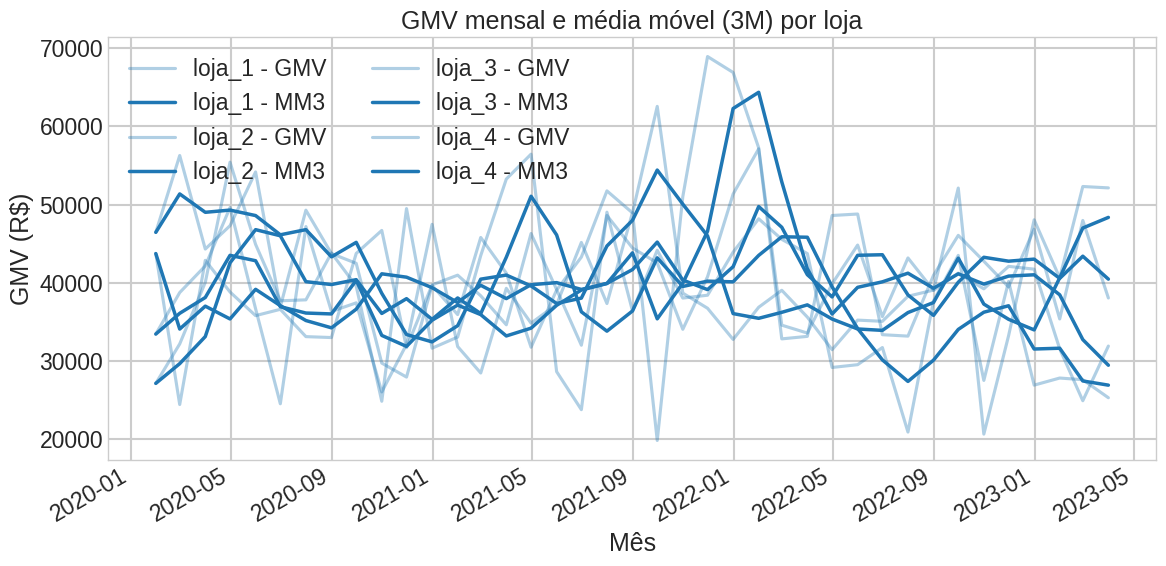

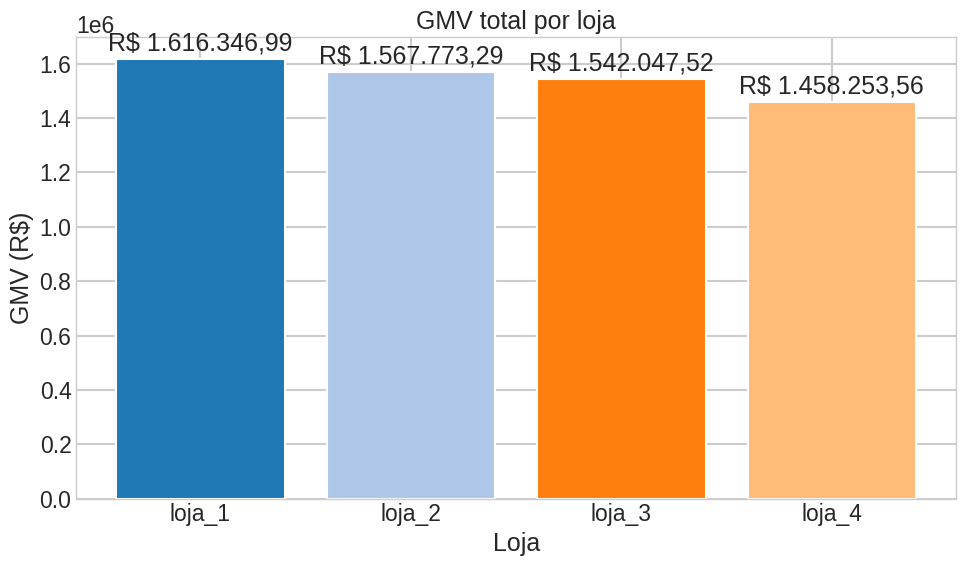

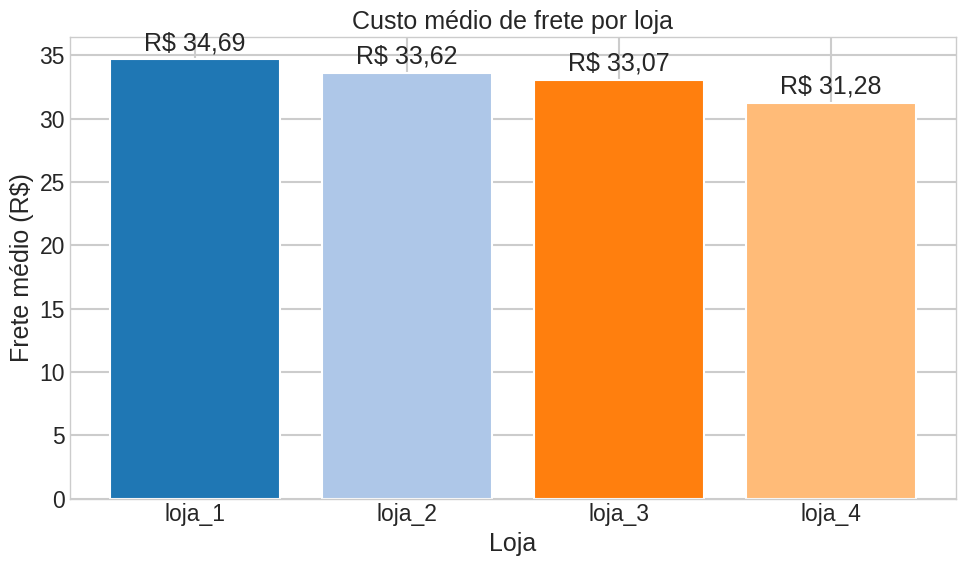

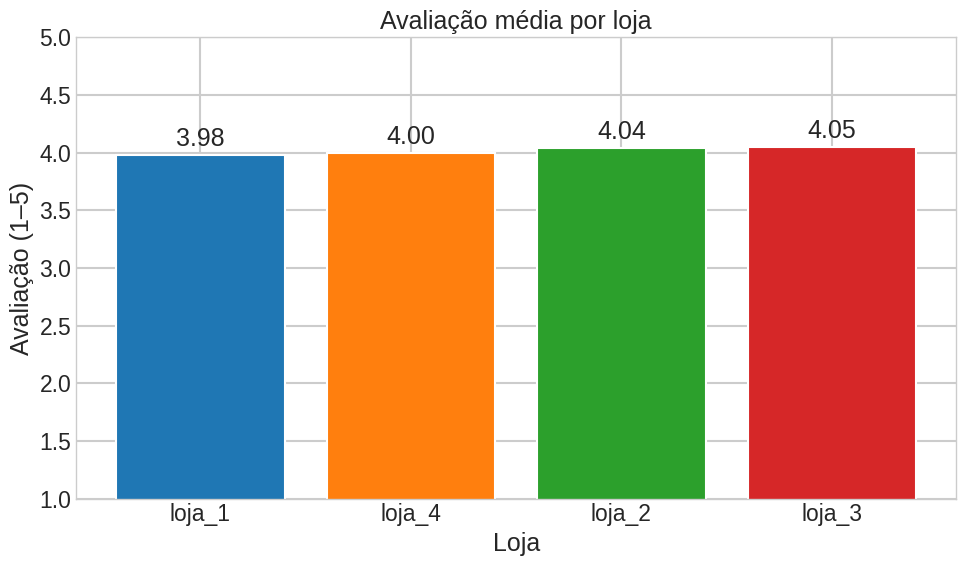

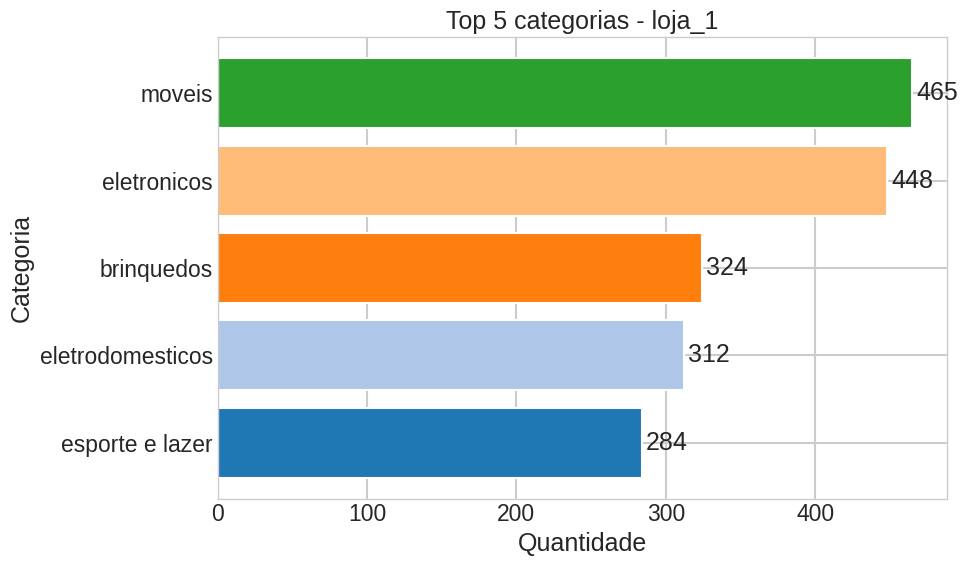

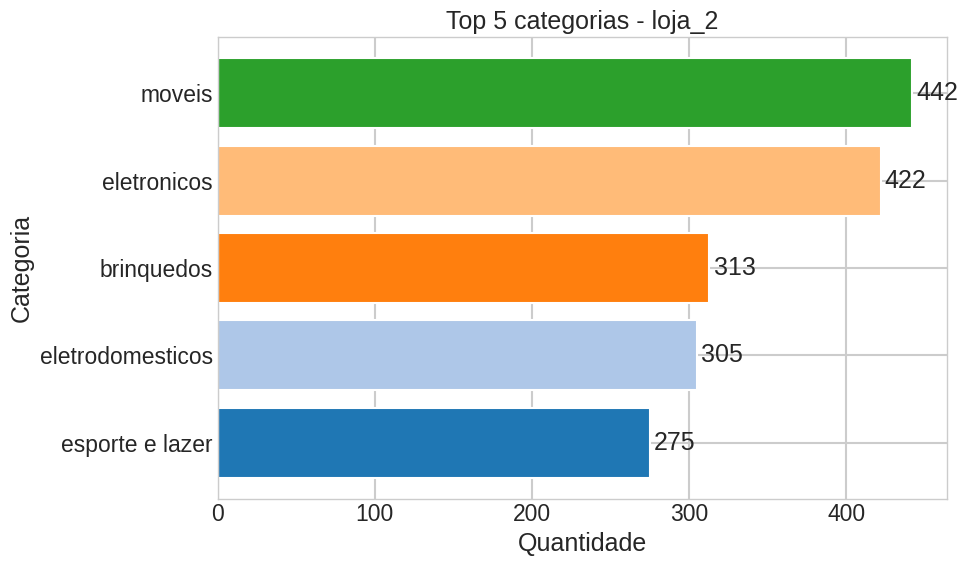

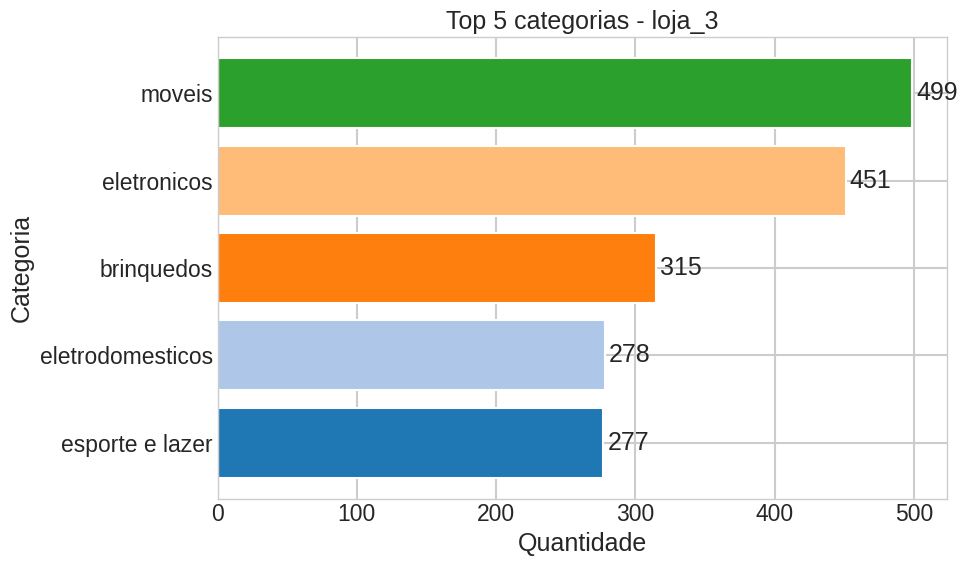

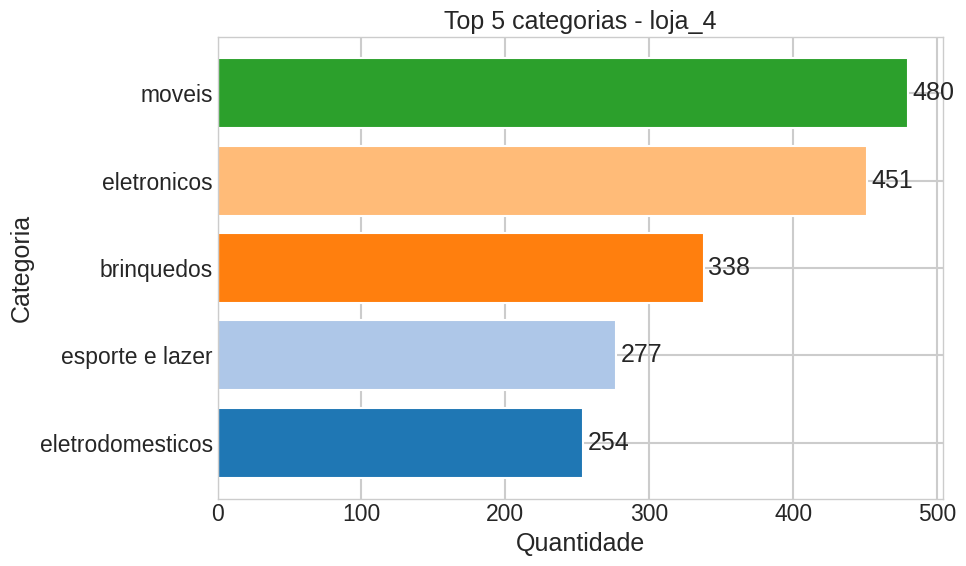

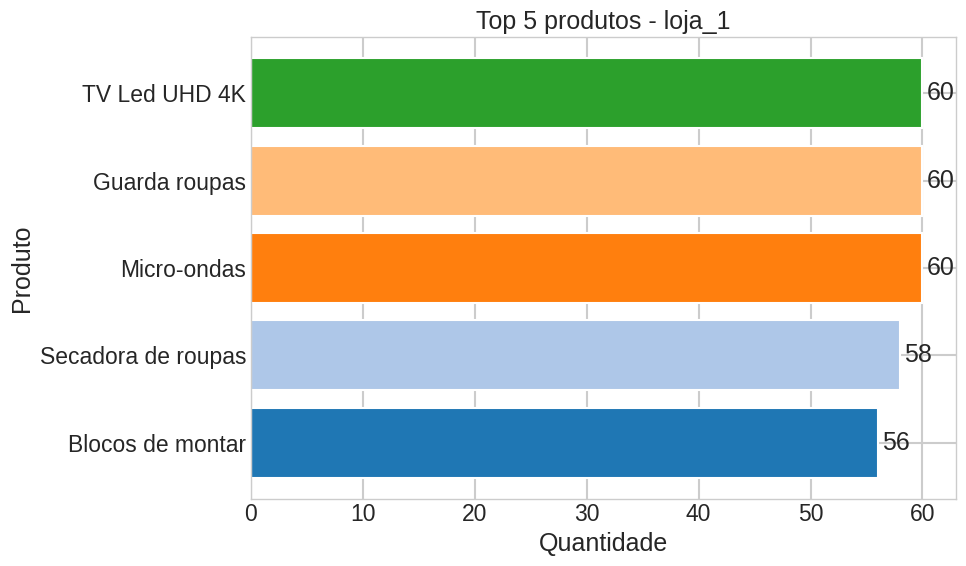

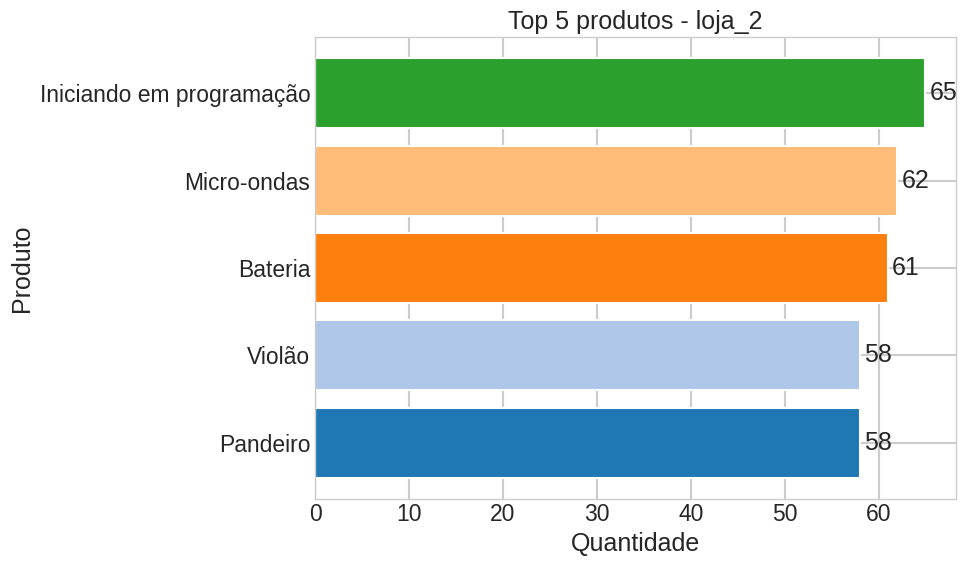

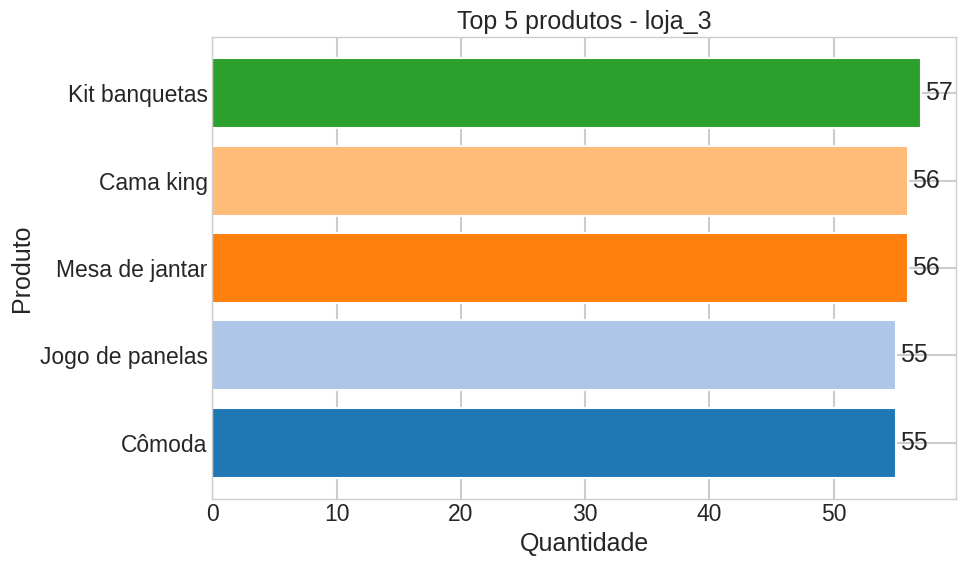

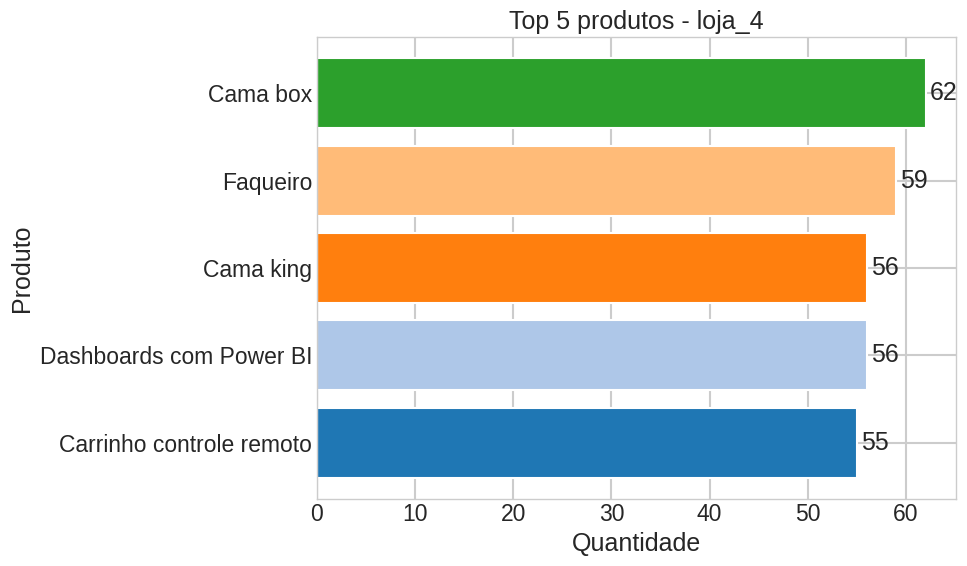

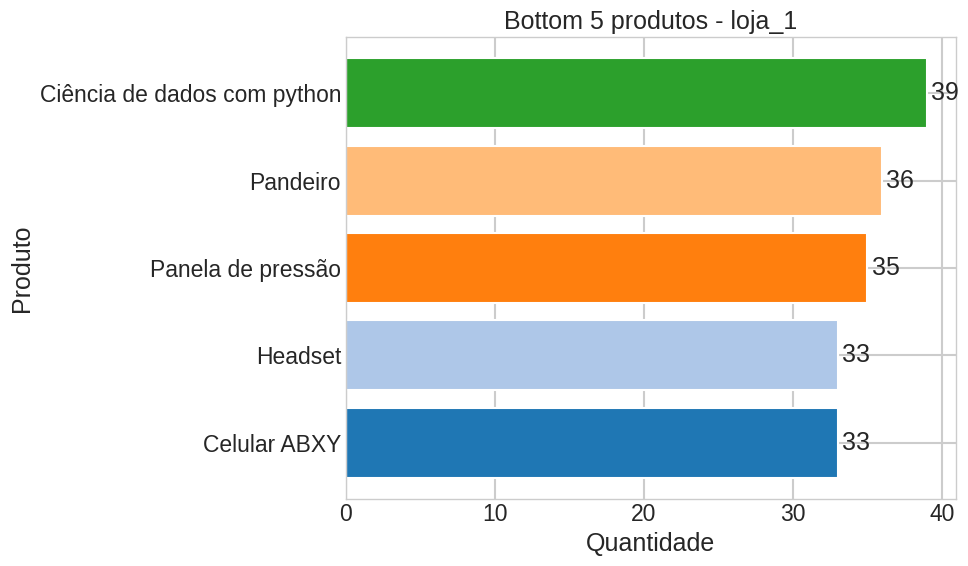

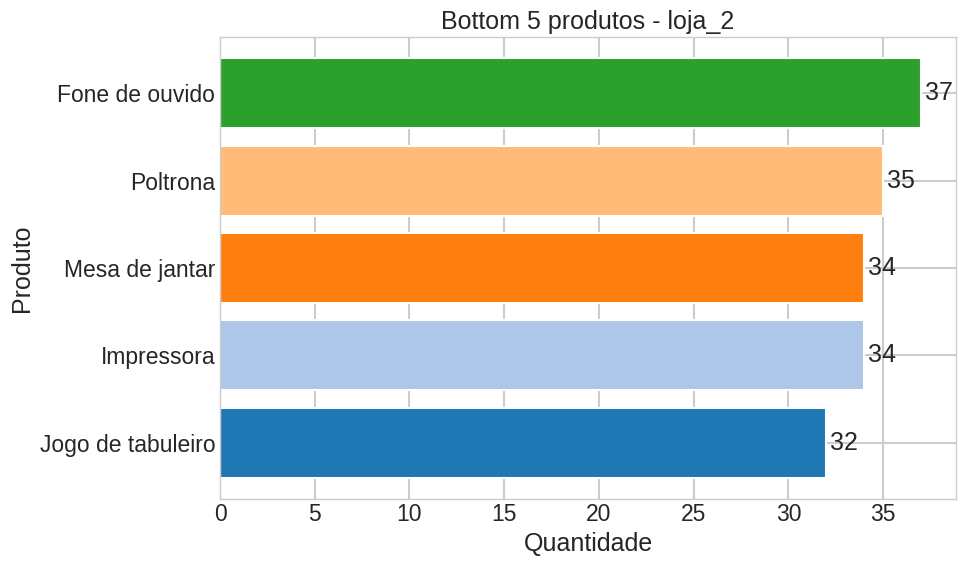

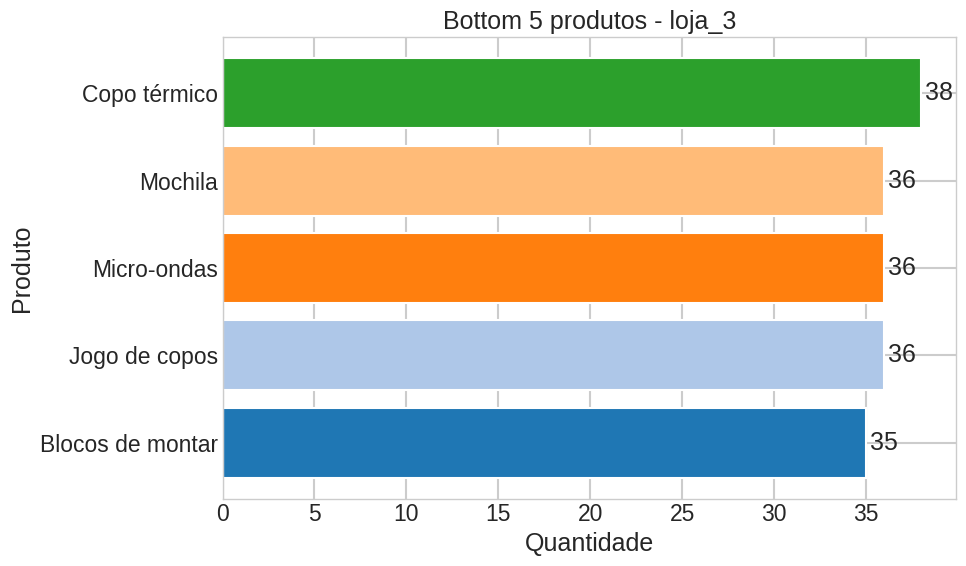

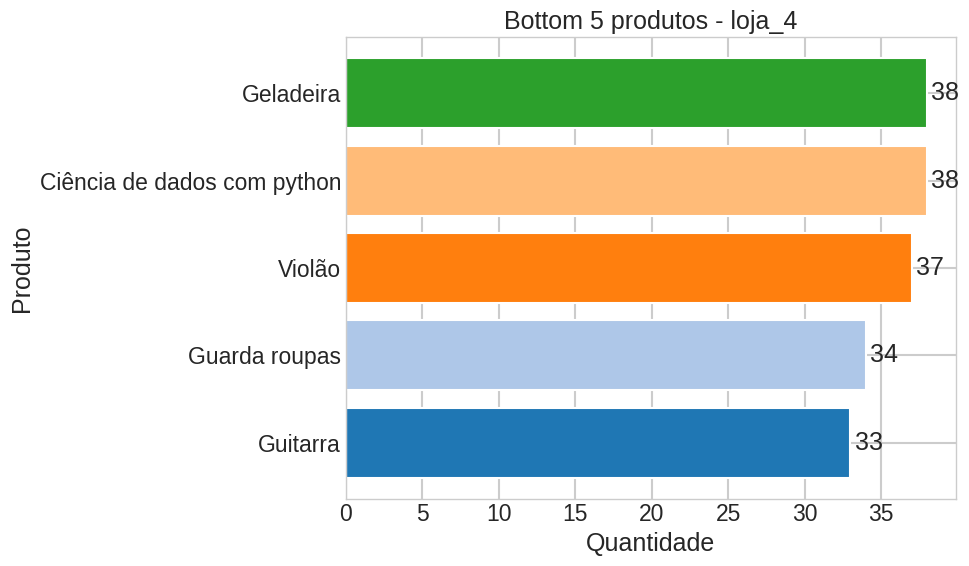

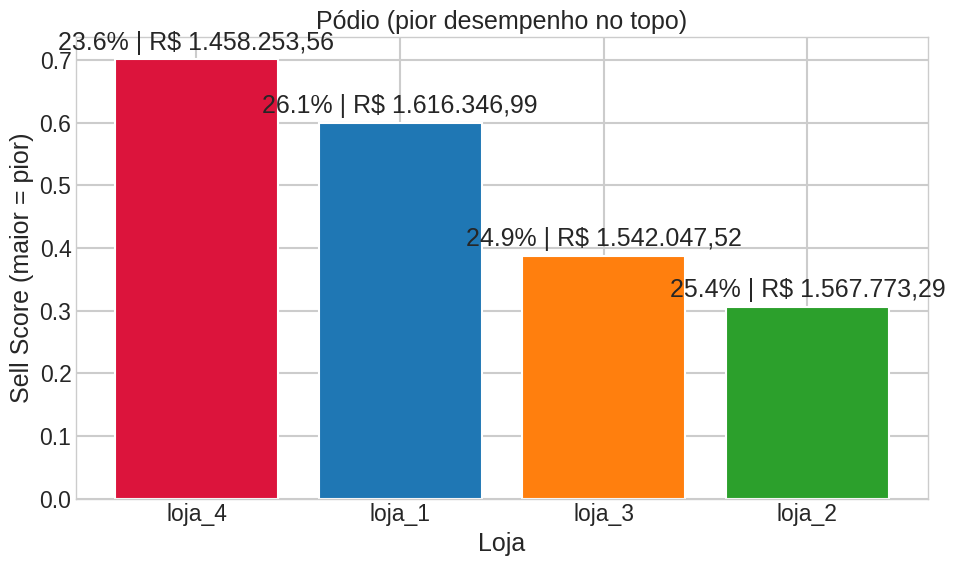

A loja a ser vendida é "loja_4".


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from babel.numbers import format_currency

# Paleta categórica para lojas
def palette_for(labels, cmap_name="tab10"):
    cmap = plt.get_cmap(cmap_name)
    return [cmap(i % cmap.N) for i in range(len(labels))]

def add_bar_labels(ax, bars, fmt=None):
    if fmt is None:
        ax.bar_label(bars, padding=3)  # Matplotlib 3.4+
    else:
        ax.bar_label(bars, labels=[fmt(v.get_height()) for v in bars], padding=3)

# 1) Linha: GMV mensal e média móvel por loja (cores variadas por loja)
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(12,6))
for i, (loja, df_) in enumerate(monthly.groupby("loja")):
    df_ = df_.sort_values("Data da Compra")
    color = palette_for([loja])[0]
    plt.plot(df_["Data da Compra"], df_["gmv_brl"], color=color, alpha=0.35, label=f"{loja} - GMV")
    plt.plot(df_["Data da Compra"], df_["gmv_mm3"], color=color, linewidth=2.5, label=f"{loja} - MM3")
plt.title("GMV mensal e média móvel (3M) por loja")
plt.xlabel("Mês"); plt.ylabel("GMV (R$)")
plt.legend(ncols=2); plt.gcf().autofmt_xdate(); plt.tight_layout(); plt.show()

# 2) Barras: GMV total por loja (cores variadas + rótulos em BRL)
fig, ax = plt.subplots(figsize=(10,6))
ordem = kpis.sort_values("gmv_brl", ascending=False)
colors = palette_for(ordem["loja"].tolist(), "tab20")
bars = ax.bar(ordem["loja"], ordem["gmv_brl"], color=colors)
ax.set_title("GMV total por loja"); ax.set_xlabel("Loja"); ax.set_ylabel("GMV (R$)")
ax.bar_label(bars, labels=[format_currency(v, "BRL", locale="pt_BR") for v in ordem["gmv_brl"]], padding=3)
plt.tight_layout(); plt.show()

# 3) Barras: Frete médio por loja (cores variadas)
fig, ax = plt.subplots(figsize=(10,6))
ordem2 = kpis.sort_values("frete_medio", ascending=False)
colors2 = palette_for(ordem2["loja"].tolist(), "tab20")
bars = ax.bar(ordem2["loja"], ordem2["frete_medio"], color=colors2)
ax.set_title("Custo médio de frete por loja"); ax.set_xlabel("Loja"); ax.set_ylabel("Frete médio (R$)")
ax.bar_label(bars, labels=[format_currency(v, "BRL", locale="pt_BR") for v in ordem2["frete_medio"]], padding=3)
plt.tight_layout(); plt.show()

# 4) Barras: Avaliação média por loja (cores variadas)
fig, ax = plt.subplots(figsize=(10,6))
ordem3 = kpis.sort_values("avaliacao_media")
colors3 = palette_for(ordem3["loja"].tolist(), "tab10")
bars = ax.bar(ordem3["loja"], ordem3["avaliacao_media"], color=colors3)
ax.set_title("Avaliação média por loja"); ax.set_xlabel("Loja"); ax.set_ylabel("Avaliação (1–5)")
ax.set_ylim(1,5)
ax.bar_label(bars, fmt="%.2f", padding=3)
plt.tight_layout(); plt.show()

# 5) Barras horizontais: Top categorias por loja (cores variadas por loja)
for loja, df_ in cats_top.groupby("loja"):
    fig, ax = plt.subplots(figsize=(10,6))
    df_plot = df_.sort_values("qtd")
    colors = palette_for(df_plot["Categoria do Produto"].tolist(), "tab20")
    bars = ax.barh(df_plot["Categoria do Produto"], df_plot["qtd"], color=colors)
    ax.set_title(f"Top {N_TOP} categorias - {loja}")
    ax.set_xlabel("Quantidade"); ax.set_ylabel("Categoria")
    ax.bar_label(bars, fmt="%.0f", padding=3)
    plt.tight_layout(); plt.show()

# 6) Top e Bottom produtos (cores variadas)
for loja, df_ in prods_top.groupby("loja"):
    fig, ax = plt.subplots(figsize=(10,6))
    df_plot = df_.sort_values("qtd")
    colors = palette_for(df_plot["Produto"].tolist(), "tab20")
    bars = ax.barh(df_plot["Produto"], df_plot["qtd"], color=colors)
    ax.set_title(f"Top {N_TOP} produtos - {loja}"); ax.set_xlabel("Quantidade"); ax.set_ylabel("Produto")
    ax.bar_label(bars, fmt="%.0f", padding=3)
    plt.tight_layout(); plt.show()

for loja, df_ in prods_bottom.groupby("loja"):
    fig, ax = plt.subplots(figsize=(10,6))
    df_plot = df_.sort_values("qtd")
    colors = palette_for(df_plot["Produto"].tolist(), "tab20")
    bars = ax.barh(df_plot["Produto"], df_plot["qtd"], color=colors)
    ax.set_title(f"Bottom {N_TOP} produtos - {loja}"); ax.set_xlabel("Quantidade"); ax.set_ylabel("Produto")
    ax.bar_label(bars, fmt="%.0f", padding=3)
    plt.tight_layout(); plt.show()

# 7) Pódio: ranking final (pior no topo)
fig, ax = plt.subplots(figsize=(10,6))
podium = m[["loja","sell_score","gmv_brl"]].copy()
total_gmv = podium["gmv_brl"].sum()
podium["share"] = (podium["gmv_brl"] / total_gmv).fillna(0.0)
podium = podium.sort_values("sell_score", ascending=False)  # pior primeiro
colors = ["crimson"] + palette_for(podium["loja"].tolist()[1:], "tab10")  # destaca a pior
bars = ax.bar(podium["loja"], podium["sell_score"], color=colors)
labels = [f'{s*100:.1f}% | {format_currency(g, "BRL", locale="pt_BR")}' for s, g in zip(podium["share"], podium["gmv_brl"])]
ax.bar_label(bars, labels=labels, padding=3)
ax.set_title("Pódio (pior desempenho no topo)"); ax.set_xlabel("Loja"); ax.set_ylabel("Sell Score (maior = pior)")
plt.tight_layout(); plt.show()

# 8) Resposta final
print(f'A loja a ser vendida é "{candidata_venda}".')


/tmp/ipython-input-4176403169.py:90: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipython-input-4176403169.py:111: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend = monthly.groupby("loja").apply(slope_trend).rename("slope_gmv").reset_index()
/tmp/ipython-input-4176403169.py:120: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cres

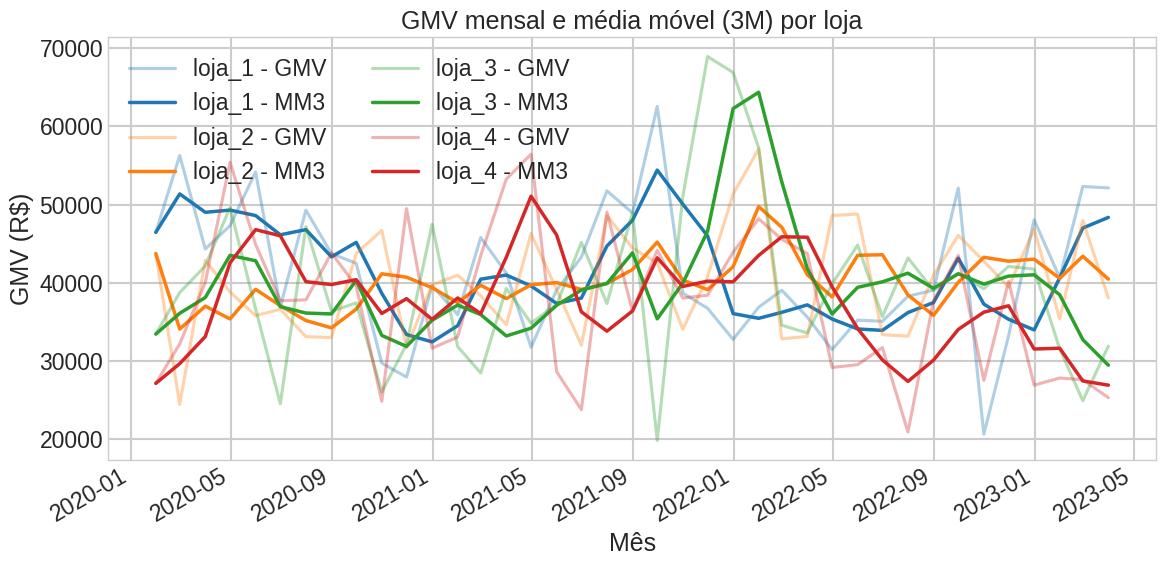

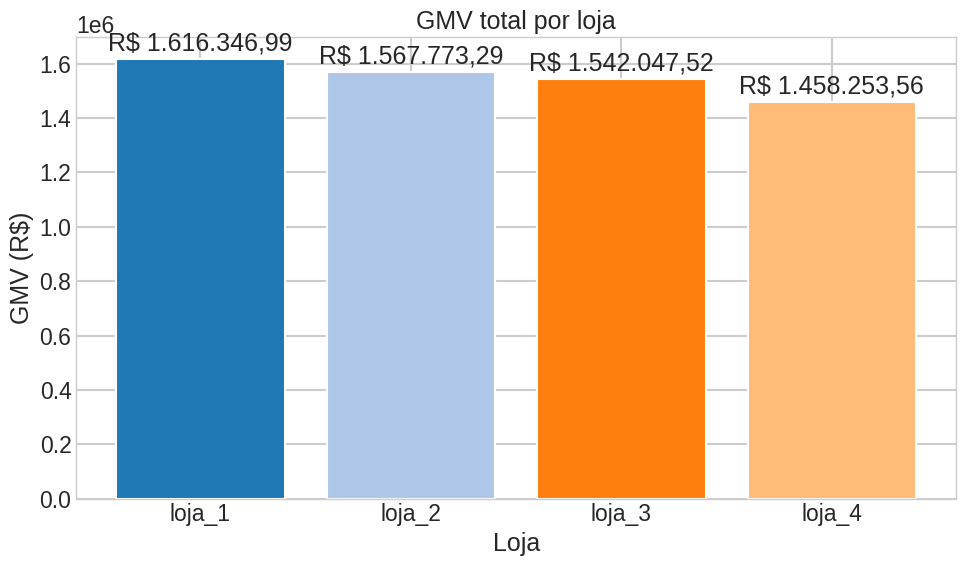

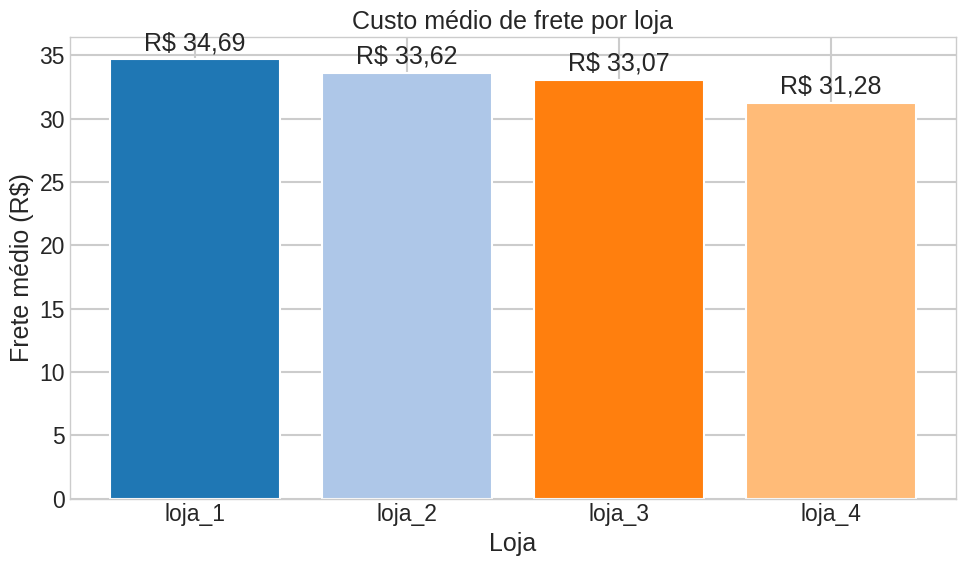

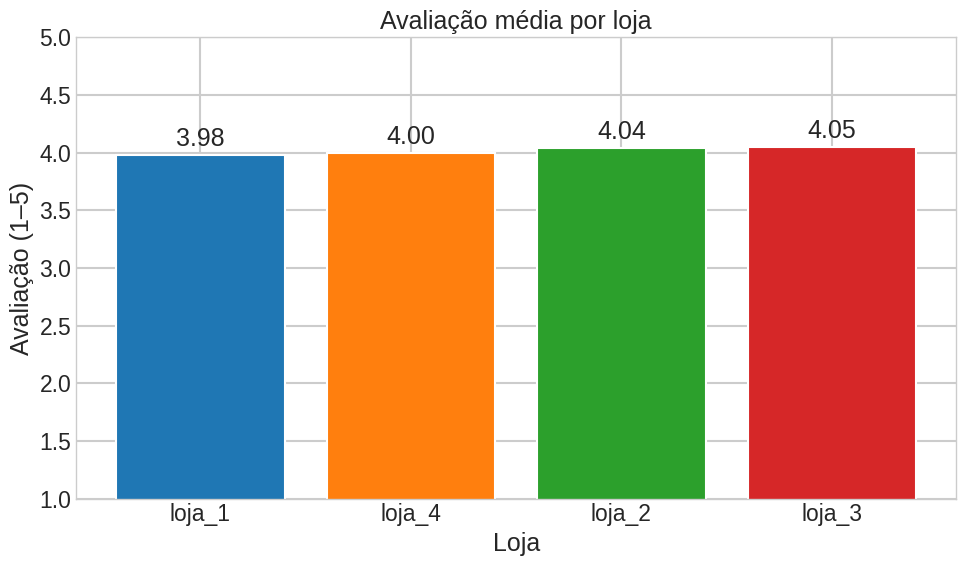

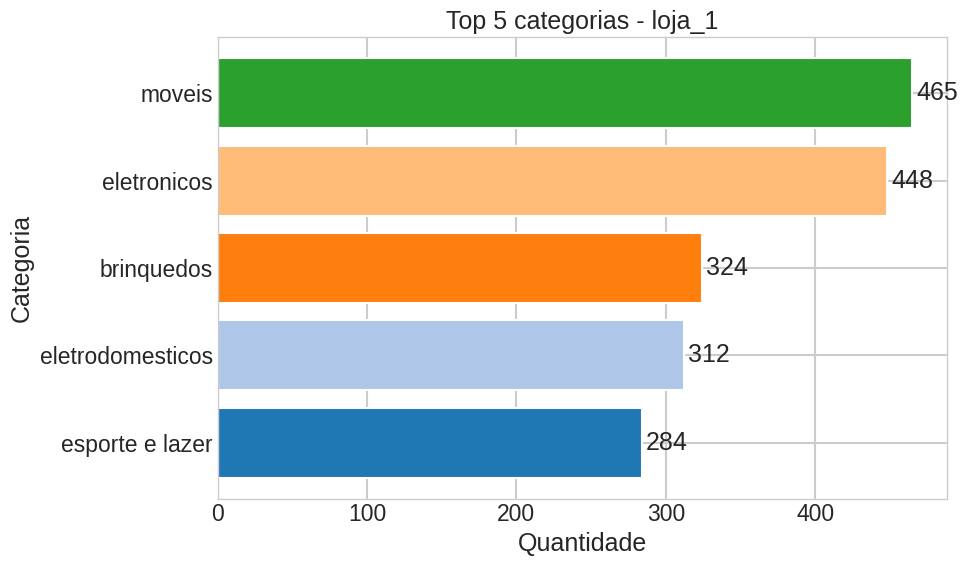

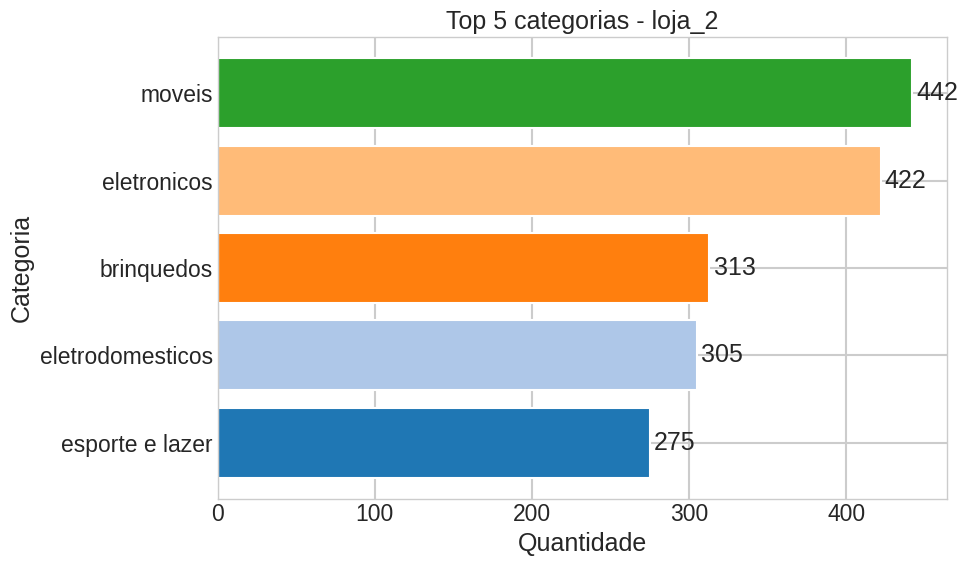

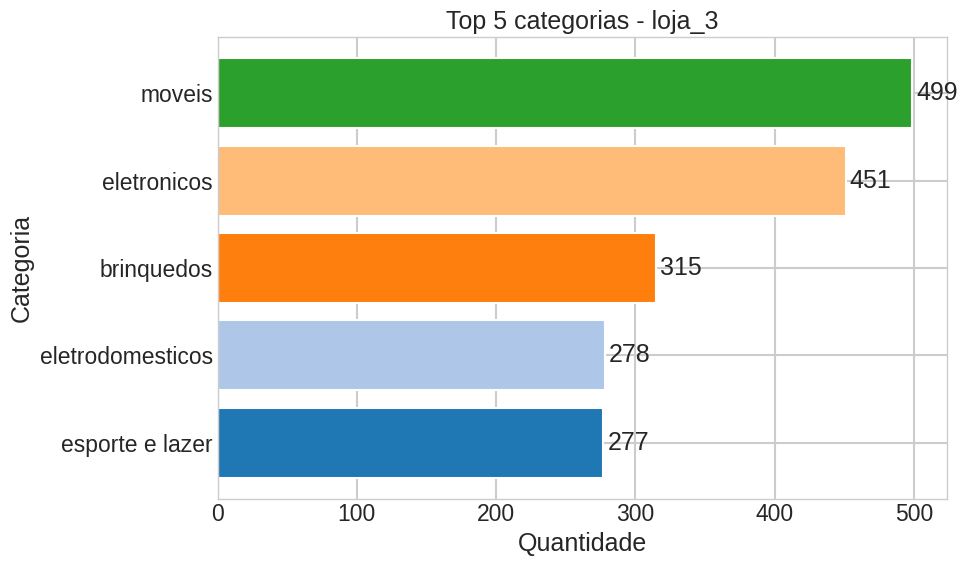

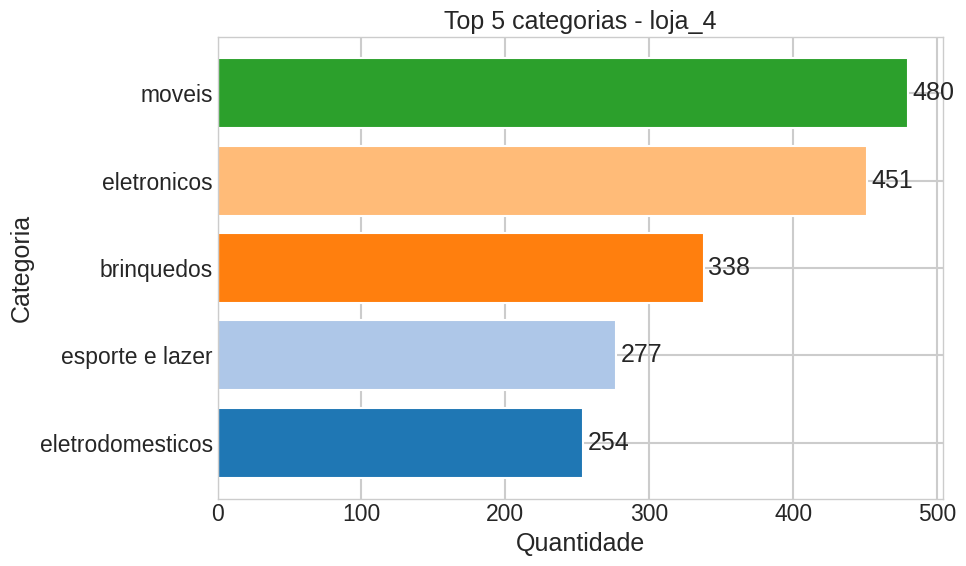

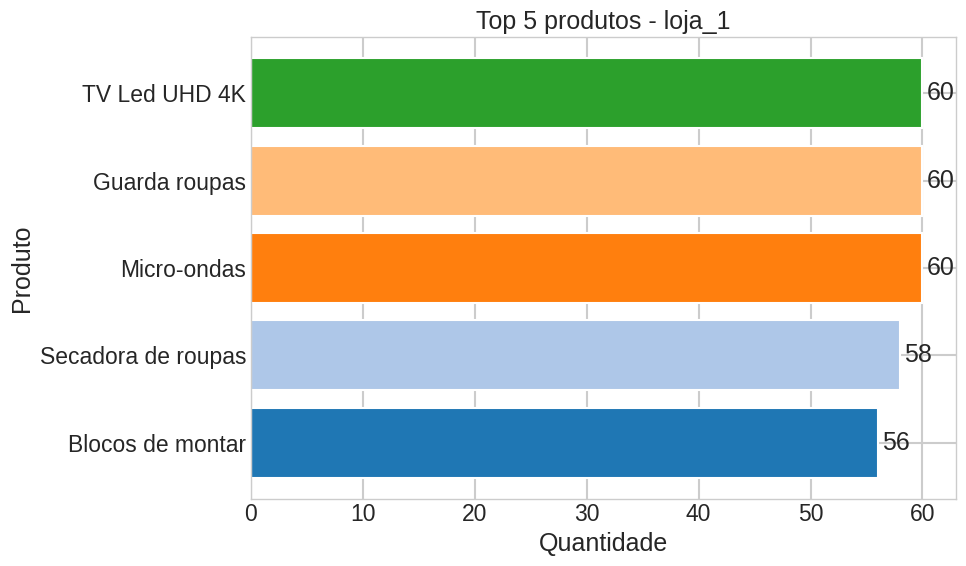

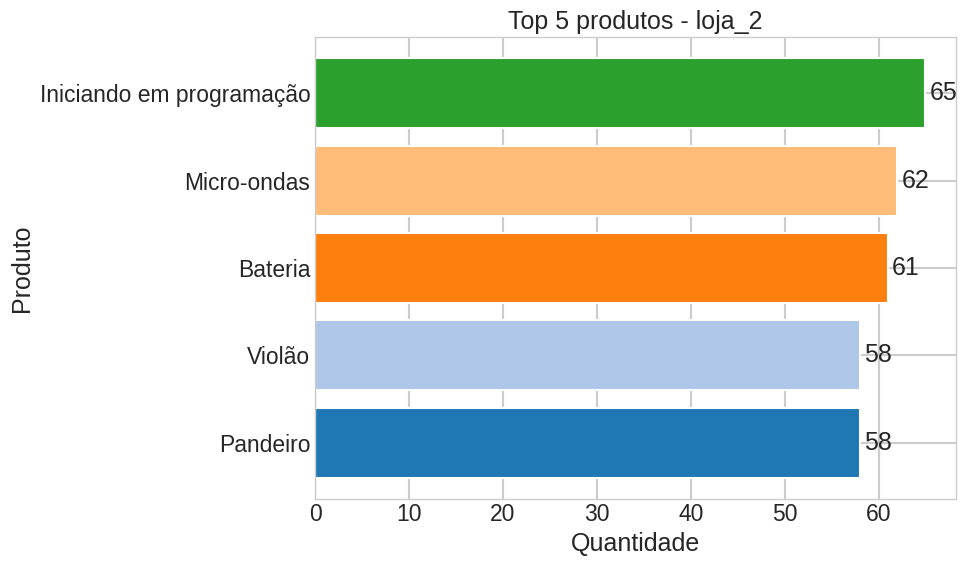

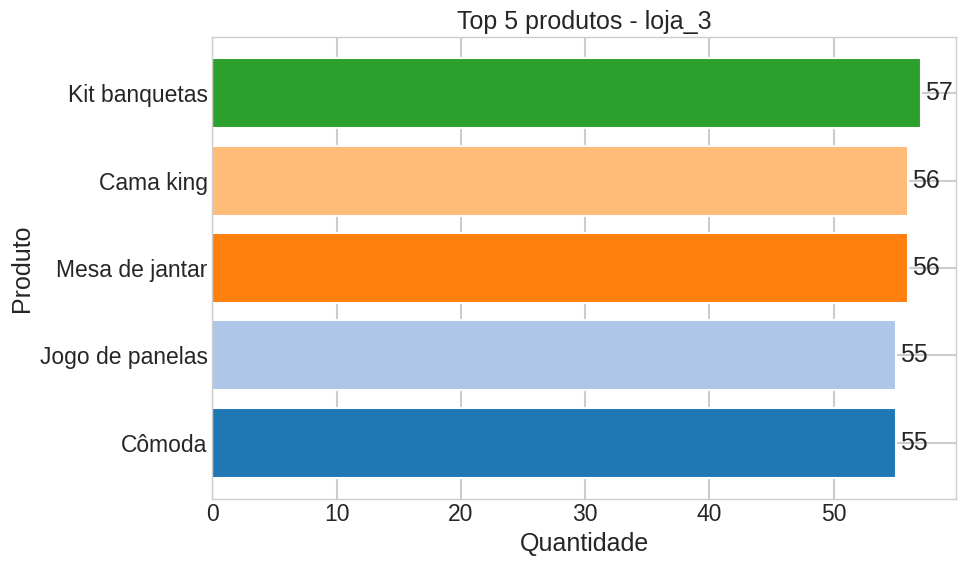

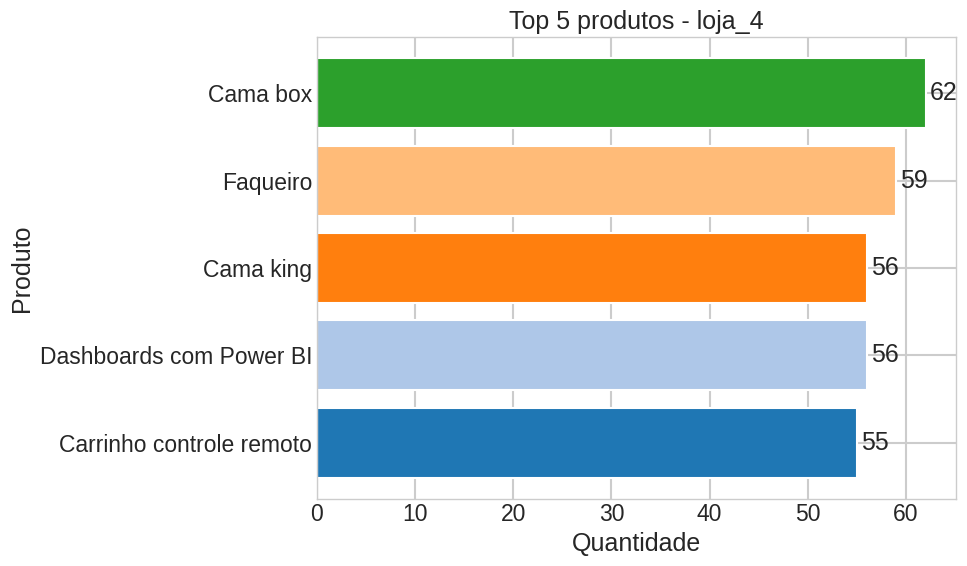

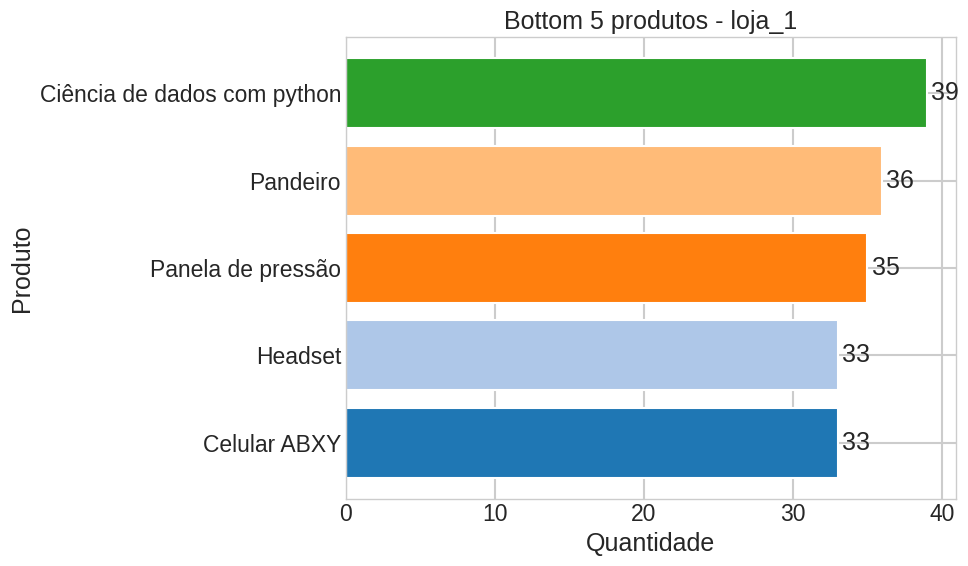

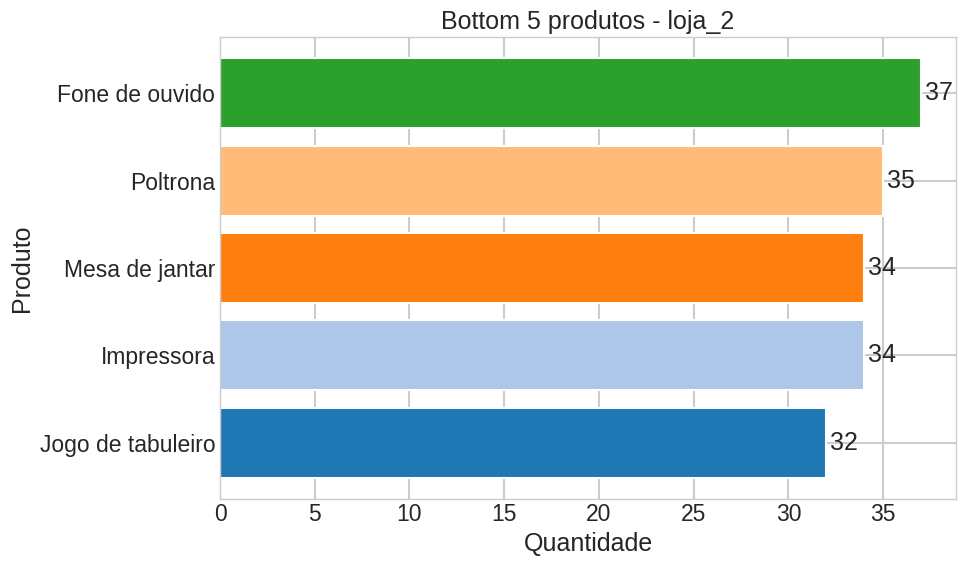

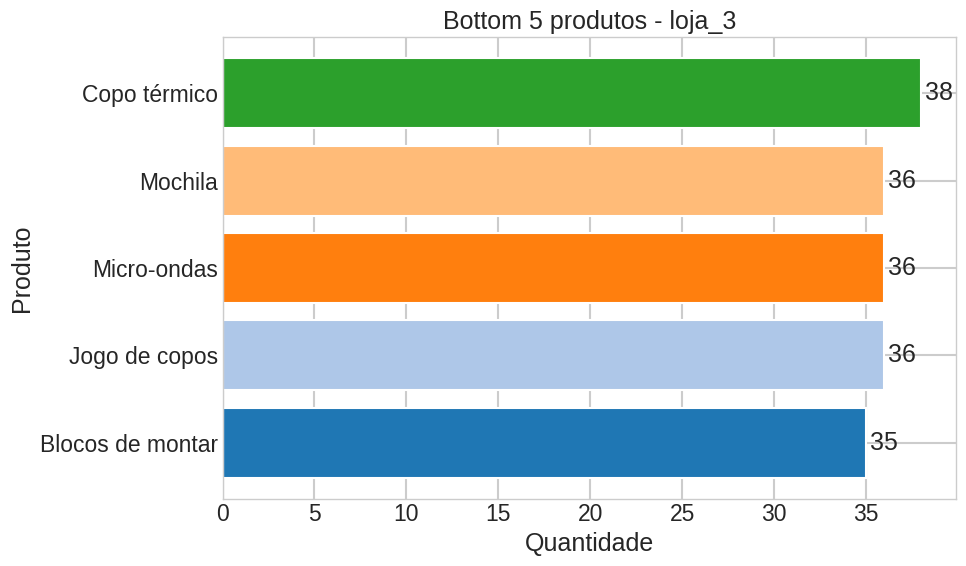

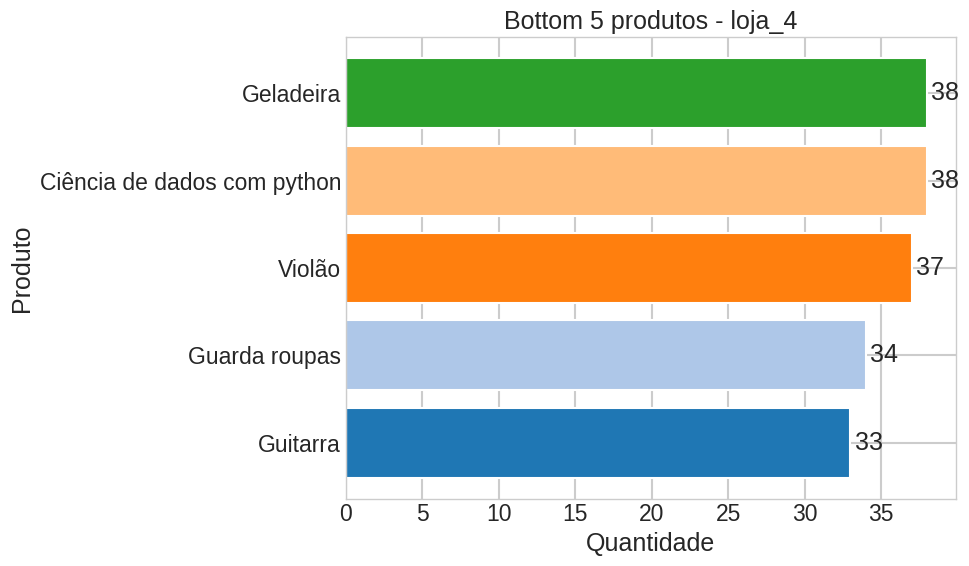

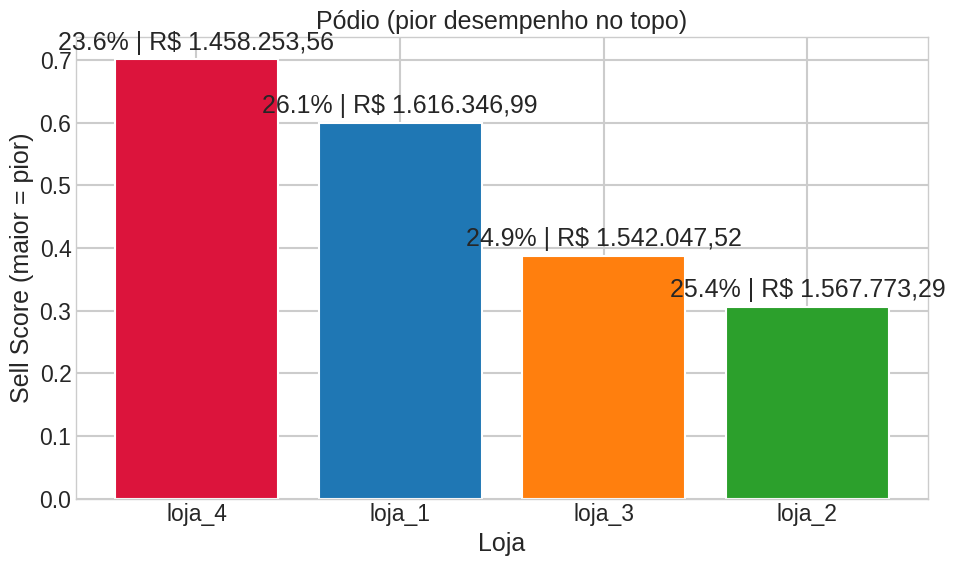

A loja a ser vendida é "loja_4".


In [57]:
# !pip install babel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_HALF_UP
from babel.numbers import format_currency

# -----------------------------
# 1) Entrada e normalização
# -----------------------------
urls_lojas = {
    'loja_1': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_1.csv",
    'loja_2': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_2.csv",
    'loja_3': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_3.csv",
    'loja_4': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_4.csv"
}

COLS = [
    "Produto","Categoria do Produto","Preço","Frete","Data da Compra",
    "Vendedor","Local da compra","Avaliação da compra","Tipo de pagamento",
    "Quantidade de parcelas","lat","lon"
]

def to_cents(x):
    if pd.isna(x): return 0
    d = Decimal(str(x)).quantize(Decimal("0.01"), rounding=ROUND_HALF_UP)
    return int(d * 100)

def carregar_normalizar(nome_loja, url):
    """
    Carrega CSV da loja e normaliza tipos e derivados.
    """
    df = pd.read_csv(url, encoding="utf-8")
    df = df[COLS]
    df["Data da Compra"] = pd.to_datetime(df["Data da Compra"], format="%d/%m/%Y", errors="coerce")
    df["Preço"] = pd.to_numeric(df["Preço"], errors="coerce")
    df["Frete"] = pd.to_numeric(df["Frete"], errors="coerce")
    for c in ["Produto","Categoria do Produto","Vendedor","Local da compra","Tipo de pagamento"]:
        df[c] = df[c].astype("string").str.strip()
    df["preco_cent"] = df["Preço"].apply(to_cents)
    df["frete_cent"] = df["Frete"].apply(to_cents)
    df["gmv_cent"]   = df["preco_cent"] + df["frete_cent"]
    df["loja"] = nome_loja
    return df

dfs = [carregar_normalizar(loja, url) for loja, url in urls_lojas.items()]
full = pd.concat(dfs, ignore_index=True).dropna(subset=["Data da Compra"])

# -----------------------------
# 2) KPIs por loja
# -----------------------------
kpis = (
    full.groupby("loja", as_index=False)
        .agg(
            pedidos=("Produto","size"),
            gmv_cent=("gmv_cent","sum"),
            receita_produtos=("Preço","sum"),
            receita_frete=("Frete","sum"),
            frete_medio=("Frete","mean"),
            avaliacao_media=("Avaliação da compra","mean"),
        )
)
kpis["gmv_brl"] = kpis["gmv_cent"]/100
kpis["frete_pct"] = (kpis["receita_frete"] / (kpis["receita_produtos"] + kpis["receita_frete"])).replace([np.inf,-np.inf], np.nan)

# -----------------------------
# 3) Categorias e produtos
# -----------------------------
N_TOP = 5
cats_top = (
    full.groupby(["loja","Categoria do Produto"])["Produto"]
        .size().reset_index(name="qtd")
        .sort_values(["loja","qtd"], ascending=[True, False])
        .groupby("loja").head(N_TOP)
)
prod_counts = (
    full.groupby(["loja","Produto"])["Produto"]
        .size().rename("qtd").reset_index()
)
prods_top = prod_counts.sort_values(["loja","qtd"], ascending=[True, False]).groupby("loja").head(N_TOP)
prods_bottom = prod_counts.sort_values(["loja","qtd"], ascending=[True, True]).groupby("loja").head(N_TOP)

# -----------------------------
# 4) Séries temporais mensais
# -----------------------------
monthly = (
    full.set_index("Data da Compra")
        .groupby("loja")
        .resample("M")
        .agg(
            gmv_cent=("gmv_cent","sum"),
            pedidos=("Produto","size"),
            receita_frete_cent=("frete_cent","sum"),
            avaliacao_media=("Avaliação da compra","mean"),
        )
        .reset_index()
)
monthly["gmv_brl"] = monthly["gmv_cent"]/100
monthly["frete_pct"] = (monthly["receita_frete_cent"]/monthly["gmv_cent"]).replace([np.inf,-np.inf], np.nan)
monthly["gmv_mm3"] = monthly.groupby("loja")["gmv_brl"].transform(lambda s: s.rolling(3, min_periods=1).mean())

def slope_trend(df):
    df = df.sort_values("Data da Compra")
    y = df["gmv_brl"].fillna(0).to_numpy()
    x = np.arange(len(y))
    if len(x) < 2: return np.nan
    m, b = np.polyfit(x, y, 1)  # coeficiente angular
    return m

trend = monthly.groupby("loja").apply(slope_trend).rename("slope_gmv").reset_index()

def pct_change_begin_end(df):
    df = df.sort_values("Data da Compra")
    start = df["gmv_mm3"].head(3).mean()
    end   = df["gmv_mm3"].tail(3).mean()
    if pd.isna(start) or start == 0: return np.nan
    return (end - start) / start

crescimento = monthly.groupby("loja").apply(pct_change_begin_end).rename("crescimento_pct").reset_index()

# -----------------------------
# 5) Score de decisão (qual vender)
# -----------------------------
m = kpis.merge(crescimento, on="loja", how="left").merge(trend, on="loja", how="left")

def minmax(s):
    s = s.astype(float)
    if s.nunique(dropna=True) <= 1:
        return pd.Series(np.zeros(len(s)), index=s.index)
    return (s - s.min()) / (s.max() - s.min())

gmv_norm   = minmax(m["gmv_brl"])
rate_norm  = minmax(m["avaliacao_media"])
frete_norm = minmax(m["frete_medio"])
cres_norm  = minmax(m["crescimento_pct"].fillna(0))

m["sell_score"] = 0.40*(1 - gmv_norm) + 0.30*(1 - rate_norm) + 0.20*(frete_norm) + 0.10*(1 - cres_norm)
m = m.sort_values("sell_score", ascending=False)
candidata_venda = m.iloc[0]["loja"]

# -----------------------------
# 6) Gráficos (Matplotlib)
# -----------------------------
plt.style.use("seaborn-v0_8-whitegrid")

def palette_for(labels, cmap_name="tab20"):
    cmap = plt.get_cmap(cmap_name)
    return [cmap(i % cmap.N) for i in range(len(labels))]

# 6.1 Linha: GMV mensal e média móvel por loja (cores variadas)
plt.figure(figsize=(12,6))
for i, (loja, df_) in enumerate(monthly.groupby("loja")):
    df_ = df_.sort_values("Data da Compra")
    color = plt.get_cmap("tab10")(i % 10)
    plt.plot(df_["Data da Compra"], df_["gmv_brl"], color=color, alpha=0.35, label=f"{loja} - GMV")
    plt.plot(df_["Data da Compra"], df_["gmv_mm3"], color=color, linewidth=2.5, label=f"{loja} - MM3")
plt.title("GMV mensal e média móvel (3M) por loja")
plt.xlabel("Mês"); plt.ylabel("GMV (R$)")
plt.legend(ncols=2); plt.gcf().autofmt_xdate(); plt.tight_layout(); plt.show()

# 6.2 Barras: GMV total por loja (multicor + rótulo BRL)
fig, ax = plt.subplots(figsize=(10,6))
ordem = kpis.sort_values("gmv_brl", ascending=False)
colors = palette_for(ordem["loja"].tolist(), "tab20")
bars = ax.bar(ordem["loja"], ordem["gmv_brl"], color=colors)
ax.set_title("GMV total por loja"); ax.set_xlabel("Loja"); ax.set_ylabel("GMV (R$)")
ax.bar_label(bars, labels=[format_currency(v, "BRL", locale="pt_BR") for v in ordem["gmv_brl"]], padding=3)
plt.tight_layout(); plt.show()

# 6.3 Barras: Frete médio por loja (multicor)
fig, ax = plt.subplots(figsize=(10,6))
ordem2 = kpis.sort_values("frete_medio", ascending=False)
colors2 = palette_for(ordem2["loja"].tolist(), "tab20")
bars = ax.bar(ordem2["loja"], ordem2["frete_medio"], color=colors2)
ax.set_title("Custo médio de frete por loja"); ax.set_xlabel("Loja"); ax.set_ylabel("Frete médio (R$)")
ax.bar_label(bars, labels=[format_currency(v, "BRL", locale="pt_BR") for v in ordem2["frete_medio"]], padding=3)
plt.tight_layout(); plt.show()

# 6.4 Barras: Avaliação média por loja (multicor)
fig, ax = plt.subplots(figsize=(10,6))
ordem3 = kpis.sort_values("avaliacao_media")
colors3 = palette_for(ordem3["loja"].tolist(), "tab10")
bars = ax.bar(ordem3["loja"], ordem3["avaliacao_media"], color=colors3)
ax.set_title("Avaliação média por loja"); ax.set_xlabel("Loja"); ax.set_ylabel("Avaliação (1–5)")
ax.set_ylim(1,5); ax.bar_label(bars, fmt="%.2f", padding=3)
plt.tight_layout(); plt.show()

# 6.5 Barras horizontais: Top categorias por loja (multicor)
for loja, df_ in cats_top.groupby("loja"):
    fig, ax = plt.subplots(figsize=(10,6))
    df_plot = df_.sort_values("qtd")
    colors = palette_for(df_plot["Categoria do Produto"].tolist(), "tab20")
    bars = ax.barh(df_plot["Categoria do Produto"], df_plot["qtd"], color=colors)
    ax.set_title(f"Top {N_TOP} categorias - {loja}")
    ax.set_xlabel("Quantidade"); ax.set_ylabel("Categoria")
    ax.bar_label(bars, fmt="%.0f", padding=3)
    plt.tight_layout(); plt.show()

# 6.6 Barras horizontais: Top e Bottom produtos por loja (multicor)
for loja, df_ in prods_top.groupby("loja"):
    fig, ax = plt.subplots(figsize=(10,6))
    df_plot = df_.sort_values("qtd")
    colors = palette_for(df_plot["Produto"].tolist(), "tab20")
    bars = ax.barh(df_plot["Produto"], df_plot["qtd"], color=colors)
    ax.set_title(f"Top {N_TOP} produtos - {loja}"); ax.set_xlabel("Quantidade"); ax.set_ylabel("Produto")
    ax.bar_label(bars, fmt="%.0f", padding=3)
    plt.tight_layout(); plt.show()

for loja, df_ in prods_bottom.groupby("loja"):
    fig, ax = plt.subplots(figsize=(10,6))
    df_plot = df_.sort_values("qtd")
    colors = palette_for(df_plot["Produto"].tolist(), "tab20")
    bars = ax.barh(df_plot["Produto"], df_plot["qtd"], color=colors)
    ax.set_title(f"Bottom {N_TOP} produtos - {loja}"); ax.set_xlabel("Quantidade"); ax.set_ylabel("Produto")
    ax.bar_label(bars, fmt="%.0f", padding=3)
    plt.tight_layout(); plt.show()

# 6.7 Pódio: ranking final (pior no topo), com share de GMV e valor
fig, ax = plt.subplots(figsize=(10,6))
podium = m[["loja","sell_score","gmv_brl"]].copy()
total_gmv = podium["gmv_brl"].sum()
podium["share"] = (podium["gmv_brl"] / total_gmv).fillna(0.0)
podium = podium.sort_values("sell_score", ascending=False)  # pior primeiro
# Cores: destaca a pior loja em vermelho
colors = ["crimson"] + [plt.get_cmap("tab10")(i % 10) for i in range(len(podium)-1)]
bars = ax.bar(podium["loja"], podium["sell_score"], color=colors)
labels = [f'{s*100:.1f}% | {format_currency(g, "BRL", locale="pt_BR")}' for s, g in zip(podium["share"], podium["gmv_brl"])]
ax.bar_label(bars, labels=labels, padding=3)
ax.set_title("Pódio (pior desempenho no topo)"); ax.set_xlabel("Loja"); ax.set_ylabel("Sell Score (maior = pior)")
plt.tight_layout(); plt.show()

# -----------------------------
# 7) Resposta final
# -----------------------------
print(f'A loja a ser vendida é "{candidata_venda}".')
